In [ ]:
# General imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Model preparation
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error

# Other
from math import sqrt

In [ ]:
import pandas as pd

#load data
df = pd.read_csv('Loan_default.csv')

# Display the first few rows of the dataframe
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


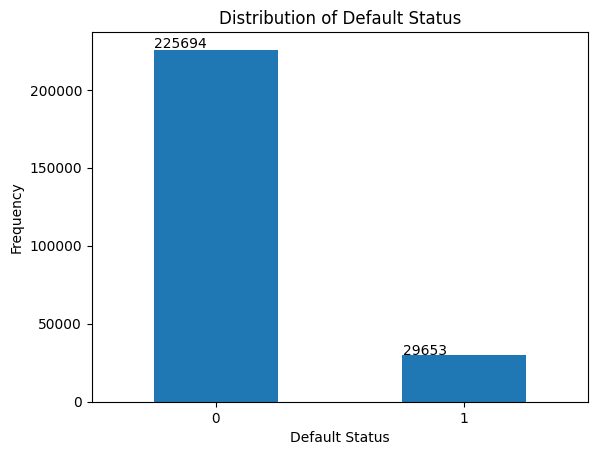

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

if 'Default' in df.columns:
    # Counting the values
    value_counts = df['Default'].value_counts()

    # Plotting the bar chart
    ax = value_counts.plot(kind='bar')
    plt.xlabel('Default Status')
    plt.ylabel('Frequency')
    plt.title('Distribution of Default Status')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=1)


    # Annotating the bar chart with the counts
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.show()
else:
    print("Column 'Default' not found in the dataset")

In [ ]:
# Evaluate target variable distribution
df.Default.mean()

0.11612824901017048

In [ ]:
import pandas as pd

# Counting the number of instances for the minority class '1'
minority_class_count = df['Default'].value_counts()[1]

# Separating the majority and minority classes
df_majority = df[df['Default'] == 0]
df_minority = df[df['Default'] == 1]

# Randomly sample from the majority class to get a subset equal to the minority class count
df_majority_downsampled = df_majority.sample(n=minority_class_count, random_state=42) # Random state for reproducibility

# Drop the old majority class from the original df
df = df.drop(df[df['Default'] == 0].index)

# Append the downsampled majority class to the original df
df = df.append(df_majority_downsampled)

# Shuffle the dataset to prevent the model from learning any order
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# df should now has an equal number of instances for each class of 'Default', HURAYYYYYYY!!!


<ipython-input-5-7dfca35353fd>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_majority_downsampled)


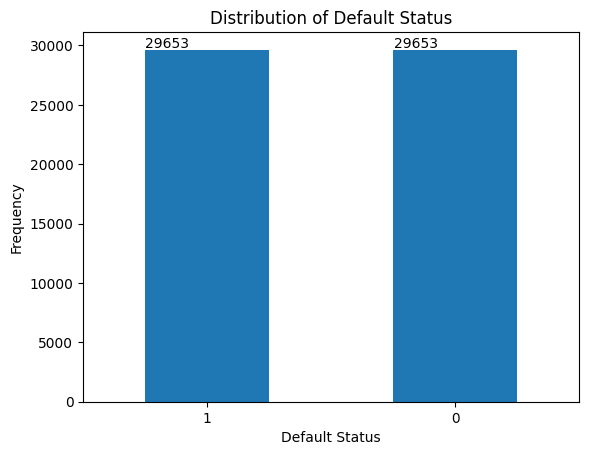

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

if 'Default' in df.columns:
    # Counting the values
    value_counts = df['Default'].value_counts()

    # Plotting the bar chart
    ax = value_counts.plot(kind='bar')
    plt.xlabel('Default Status')
    plt.ylabel('Frequency')
    plt.title('Distribution of Default Status')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=1)


    # Annotating the bar chart with the counts
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.show()
else:
    print("Column 'Default' not found in the dataset")


In [ ]:
# Evaluate target variable distribution
df.Default.mean()

0.5

In [ ]:
# Check if 'LoanID' column exists
if 'LoanID' in df.columns:
    # Drop the 'LoanID' column
    df = df.drop('LoanID', axis=1)
    print("Column 'LoanID' has been removed.")
else:
    print("Column 'LoanID' not found in the dataset")


Column 'LoanID' has been removed.


In [ ]:
# Select only numeric columns (excluding the target variable 'Default')
numeric_cols = df.select_dtypes(include=[np.number]).drop('Default', axis=1)

# Calculate Q1, Q3, and IQR
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Determine outliers using IQR
outliers = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))


In [ ]:
# Count number of outliers in each row (excluding the target variable 'Default')
outliers_count = outliers.sum(axis=1)

# Count the total number of records that have at least one outlier
records_with_outliers = outliers_count[outliers_count > 0].count()

print(f"Number of records with outliers: {records_with_outliers}")


Number of records with outliers: 0


In [ ]:
# View the records with outliers to double check there are no outliars
records_with_outliers_df = df[outliers_count > 0]
print(records_with_outliers_df)


Empty DataFrame
Columns: [Age, Income, LoanAmount, CreditScore, MonthsEmployed, NumCreditLines, InterestRate, LoanTerm, DTIRatio, Education, EmploymentType, MaritalStatus, HasMortgage, HasDependents, LoanPurpose, HasCoSigner, Default]
Index: []


In [ ]:
# Columns that are predictors - replace with your actual predictor column names
predictors = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
              'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
              'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
              'HasDependents', 'LoanPurpose', 'HasCoSigner']

# Column that is the outcome
outcome = 'Default'

# Features matrix and Target vector
X = df[predictors]  # Features matrix
y = df[outcome]     # Target vector


In [ ]:
predictors = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
              'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
              'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
              'HasDependents', 'LoanPurpose', 'HasCoSigner']

# Outcome variable
outcome = 'Default'

# Converting categorical variables into dummy/indicator variables, excluding the first category of each
X_dummies = pd.get_dummies(df[predictors], drop_first=True)

# Outcome variable remains the same
y = df[outcome]

# Import train_test_split function from sklearn
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_X, valid_X, train_y, valid_y = train_test_split(X_dummies, y, test_size=0.3, random_state=1)


# Boosted Tree

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initializing the AdaBoostClassifier with 100 decision trees
ada_boost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)

# Fiting the model on the training data
ada_boost_clf.fit(train_X, train_y)

# Predicting on the validation data
y_pred_ada = ada_boost_clf.predict(valid_X)

# Calculating accuracy
accuracy = accuracy_score(valid_y, y_pred_ada)
print(f"Accuracy: {accuracy}")

# Generating a classification report
print(classification_report(valid_y, y_pred_ada))

# Generating and print confusion matrix
conf_matrix = confusion_matrix(valid_y, y_pred_ada)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.684970773381295
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      8999
           1       0.67      0.70      0.69      8793

    accuracy                           0.68     17792
   macro avg       0.69      0.69      0.68     17792
weighted avg       0.69      0.68      0.68     17792

Confusion Matrix:
[[6026 2973]
 [2632 6161]]


In [ ]:
from sklearn.metrics import roc_auc_score
y_pred_bt = ada_boost_clf.predict(valid_X)

print('ROC AUC: ', roc_auc_score(valid_y,ada_boost_clf.predict_proba(valid_X)[:,1]))

ROC AUC:  0.7531003072014509


ROC AUC:  0.7531003072014509


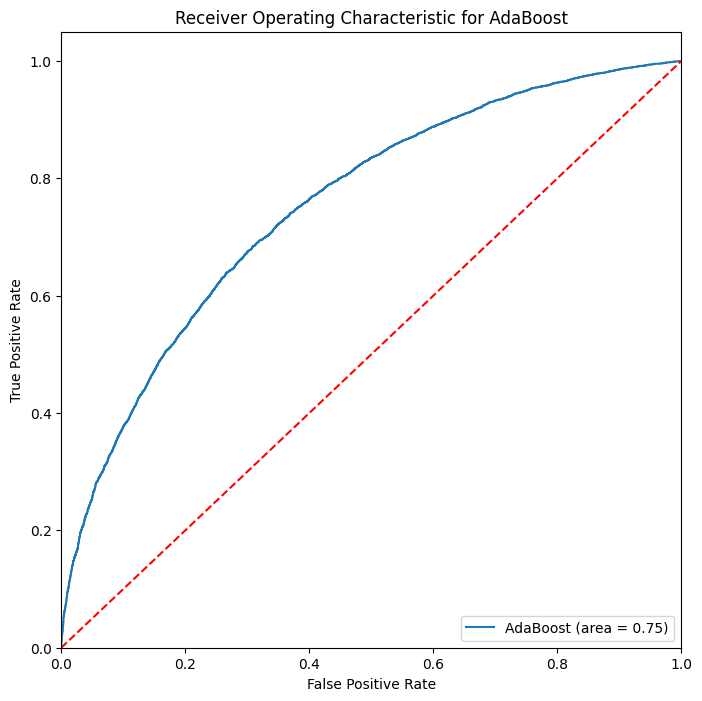

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming ada_boost_clf is your trained AdaBoostClassifier model
y_pred_bt_proba = ada_boost_clf.predict_proba(valid_X)[:, 1]

# Print ROC AUC
print('ROC AUC: ', roc_auc_score(valid_y, y_pred_bt_proba))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(valid_y, y_pred_bt_proba)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='AdaBoost (area = %0.2f)' % roc_auc_score(valid_y, y_pred_bt_proba))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for AdaBoost')
plt.legend(loc="lower right")
plt.savefig('AdaBoost_ROC')
plt.show()

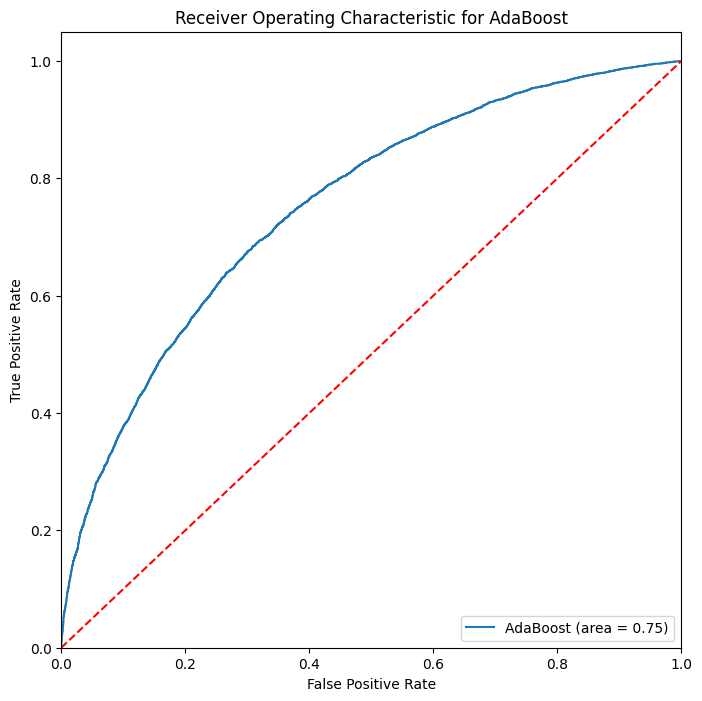

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming ada_boost_clf is your trained AdaBoostClassifier model
ada_roc_auc = roc_auc_score(valid_y, ada_boost_clf.predict_proba(valid_X)[:, 1])
ada_fpr, ada_tpr, ada_thresholds = roc_curve(valid_y, ada_boost_clf.predict_proba(valid_X)[:, 1])

plt.figure(figsize=(8, 8))
plt.plot(ada_fpr, ada_tpr, label='AdaBoost (area = %0.2f)' % ada_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for AdaBoost')
plt.legend(loc="lower right")
plt.savefig('AdaBoost_ROC')
plt.show()

Accuracy: 0.684970773381295
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      8999
           1       0.67      0.70      0.69      8793

    accuracy                           0.68     17792
   macro avg       0.69      0.69      0.68     17792
weighted avg       0.69      0.68      0.68     17792

Confusion Matrix:
[[6026 2973]
 [2632 6161]]
ROC AUC:  0.7531003072014509


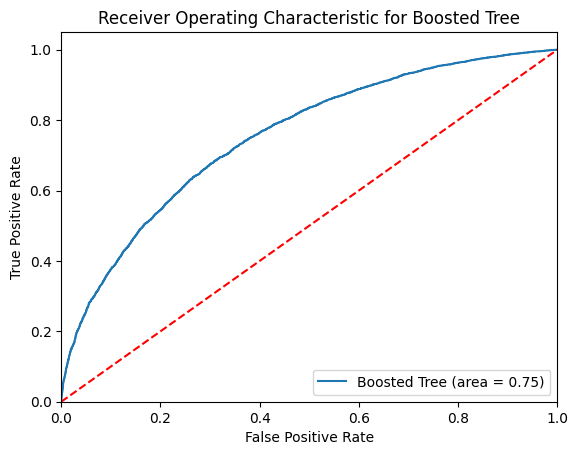

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Initializing the AdaBoostClassifier with 100 decision trees
ada_boost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)

# Fitting the model on the training data
ada_boost_clf.fit(train_X, train_y)

# Predicting on the validation data
y_pred_ada = ada_boost_clf.predict(valid_X)

# Calculating accuracy
accuracy = accuracy_score(valid_y, y_pred_ada)
print(f"Accuracy: {accuracy}")

# Generating a classification report
print("Classification Report:")
print(classification_report(valid_y, y_pred_ada))

# Generating and print confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(valid_y, y_pred_ada)
print(conf_matrix)

# Calculating ROC AUC
roc_auc = roc_auc_score(valid_y, ada_boost_clf.predict_proba(valid_X)[:, 1])
print('ROC AUC: ', roc_auc)

# Plotting ROC curve
fpr, tpr, thresholds = roc_curve(valid_y, ada_boost_clf.predict_proba(valid_X)[:, 1])

plt.figure()
plt.plot(fpr, tpr, label='Boosted Tree (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Boosted Tree')
plt.legend(loc="lower right")
plt.savefig('BoostedTree_ROC')
plt.show()


In [ ]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=fe6a4b848130b71bfd2dd999961094542c9e087e4aafbd137c004805c28c9628
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


# Feature Importance Boosted Model

In [ ]:
import eli5

from eli5.sklearn import PermutationImportance

perm = PermutationImportance(ada_boost_clf).fit(valid_X, valid_y)
eli5.show_weights(perm,  feature_names = valid_X.columns.tolist())

Weight,Feature
0.0638 ± 0.0037,Age
0.0416 ± 0.0024,InterestRate
0.0250 ± 0.0050,Income
0.0206 ± 0.0025,MonthsEmployed
0.0111 ± 0.0034,LoanAmount
0.0045 ± 0.0026,EmploymentType_Unemployed
0.0027 ± 0.0011,CreditScore
0.0022 ± 0.0018,HasDependents_Yes
0.0018 ± 0.0023,HasCoSigner_Yes
0.0009 ± 0.0003,Education_PhD


In [ ]:
perm = PermutationImportance(ada_boost_clf, random_state=1, scoring='roc_auc').fit(valid_X, valid_y)
eli5.show_weights(perm, feature_names = valid_X.columns.tolist())

Weight,Feature
0.0812 ± 0.0060,Age
0.0509 ± 0.0041,InterestRate
0.0369 ± 0.0034,Income
0.0273 ± 0.0022,MonthsEmployed
0.0161 ± 0.0022,LoanAmount
0.0067 ± 0.0018,EmploymentType_Unemployed
0.0039 ± 0.0009,HasCoSigner_Yes
0.0037 ± 0.0003,CreditScore
0.0034 ± 0.0008,HasDependents_Yes
0.0028 ± 0.0007,NumCreditLines


In [ ]:
selected_features = ['InterestRate', 'Income', 'MonthsEmployed']
df[selected_features].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
InterestRate,59306.0,14.542520,6.619974,2.0,8.97,15.03,20.39,25.0
Income,59306.0,77895.028345,40118.669099,15004.0,41716.25,76246.00,112800.50,149999.0
MonthsEmployed,59306.0,55.565019,34.745549,0.0,25.00,54.00,85.00,119.0


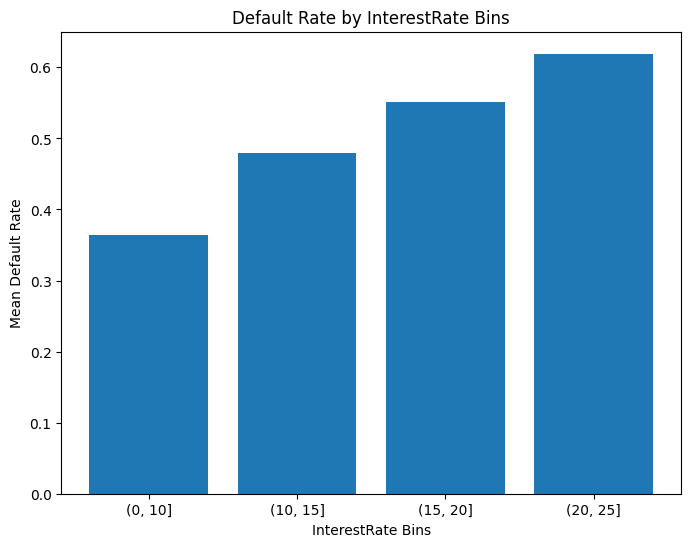

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
interest_rate_bins = [0, 10, 15, 20, 25]

# Apply binning to create a new categorical column
df['InterestRateBin'] = pd.cut(df['InterestRate'], bins=interest_rate_bins)

# Group by the binned feature and calculate mean and count
interest_rate_summary = df.groupby('InterestRateBin')['Default'].agg(['mean', 'size']).reset_index()

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary['mean'])
plt.title('Default Rate by InterestRate Bins')
plt.xlabel('InterestRate Bins')
plt.ylabel('Mean Default Rate')
plt.show()


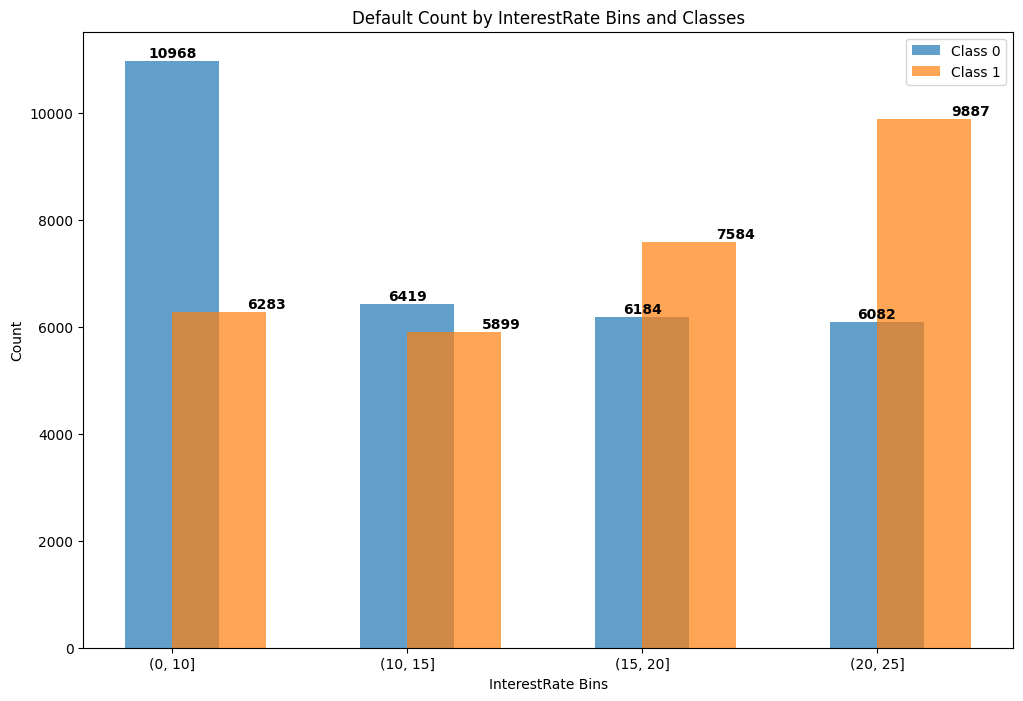

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
interest_rate_bins = [0, 10, 15, 20, 25]

# Apply binning to create a new categorical column
df['InterestRateBin'] = pd.cut(df['InterestRate'], bins=interest_rate_bins)

# Group by the binned feature and calculate counts for both classes
interest_rate_summary = df.groupby(['InterestRateBin', 'Default'])['Default'].count().unstack().reset_index()

# Plot the results
plt.figure(figsize=(12, 8))

# Bar chart for class 0
plt.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary[0], label='Class 0', alpha=0.7, width=0.4)

# Bar chart for class 1, shifted to the right
plt.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary[1], label='Class 1', alpha=0.7, width=0.4, align='edge')

# Add counts on top of the bars
for i, v in enumerate(interest_rate_summary[0]):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', color='black', fontweight='bold')

for i, v in enumerate(interest_rate_summary[1]):
    plt.text(i + 0.4, v + 10, str(v), ha='center', va='bottom', color='black', fontweight='bold')

# Add labels and legend
plt.title('Default Count by InterestRate Bins and Classes')
plt.xlabel('InterestRate Bins')
plt.ylabel('Count')
plt.legend()

plt.show()


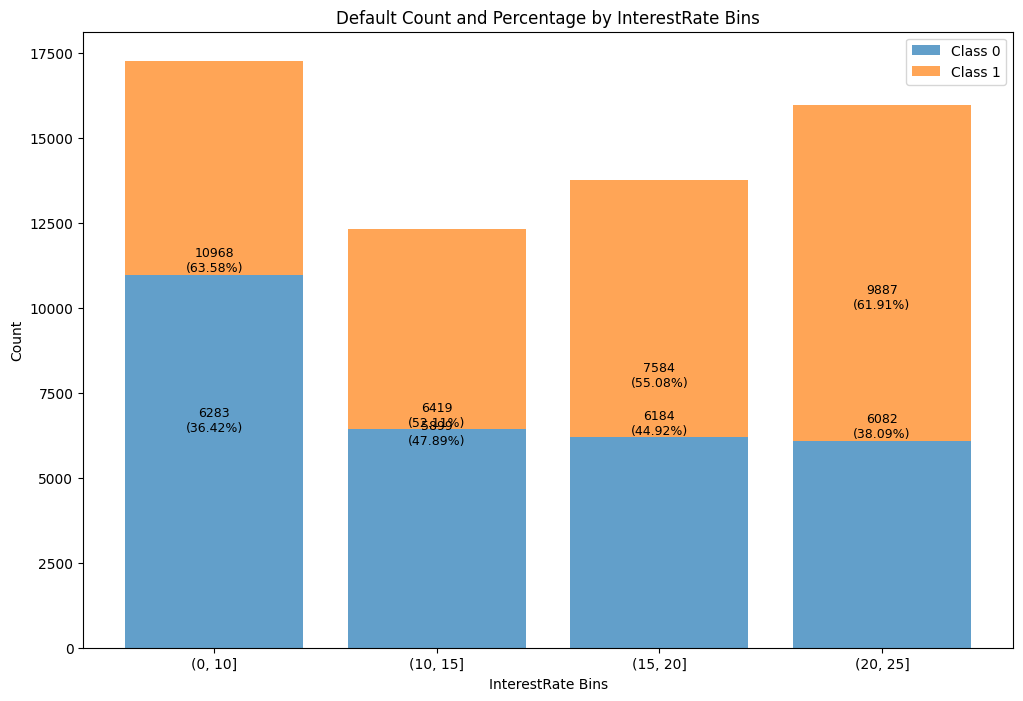

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
interest_rate_bins = [0, 10, 15, 20, 25]

# Apply binning to create a new categorical column
df['InterestRateBin'] = pd.cut(df['InterestRate'], bins=interest_rate_bins)

# Group by the binned feature and calculate count for both classes
interest_rate_summary = df.groupby(['InterestRateBin', 'Default'])['Default'].count().unstack().reset_index()

# Calculate the total count for each bin
interest_rate_summary['Total'] = interest_rate_summary[0] + interest_rate_summary[1]

# Calculate the percentage for each class
interest_rate_summary['Percentage 0'] = (interest_rate_summary[0] / interest_rate_summary['Total']) * 100
interest_rate_summary['Percentage 1'] = (interest_rate_summary[1] / interest_rate_summary['Total']) * 100

# Plot the results
plt.figure(figsize=(12, 8))

# Plot bar chart for class 0
bars1 = plt.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary[0], label='Class 0', alpha=0.7)

# Plot bar chart for class 1
bars2 = plt.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary[1], label='Class 1', alpha=0.7, bottom=interest_rate_summary[0])

# Annotate bars with count and percentage
for bars, percentage in zip([bars1, bars2], ['Percentage 0', 'Percentage 1']):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{int(yval)}\n({interest_rate_summary.loc[bars.index(bar), percentage]:.2f}%)', va='bottom', ha='center', fontsize=9)

plt.title('Default Count and Percentage by InterestRate Bins')
plt.xlabel('InterestRate Bins')
plt.ylabel('Count')
plt.legend()

plt.show()




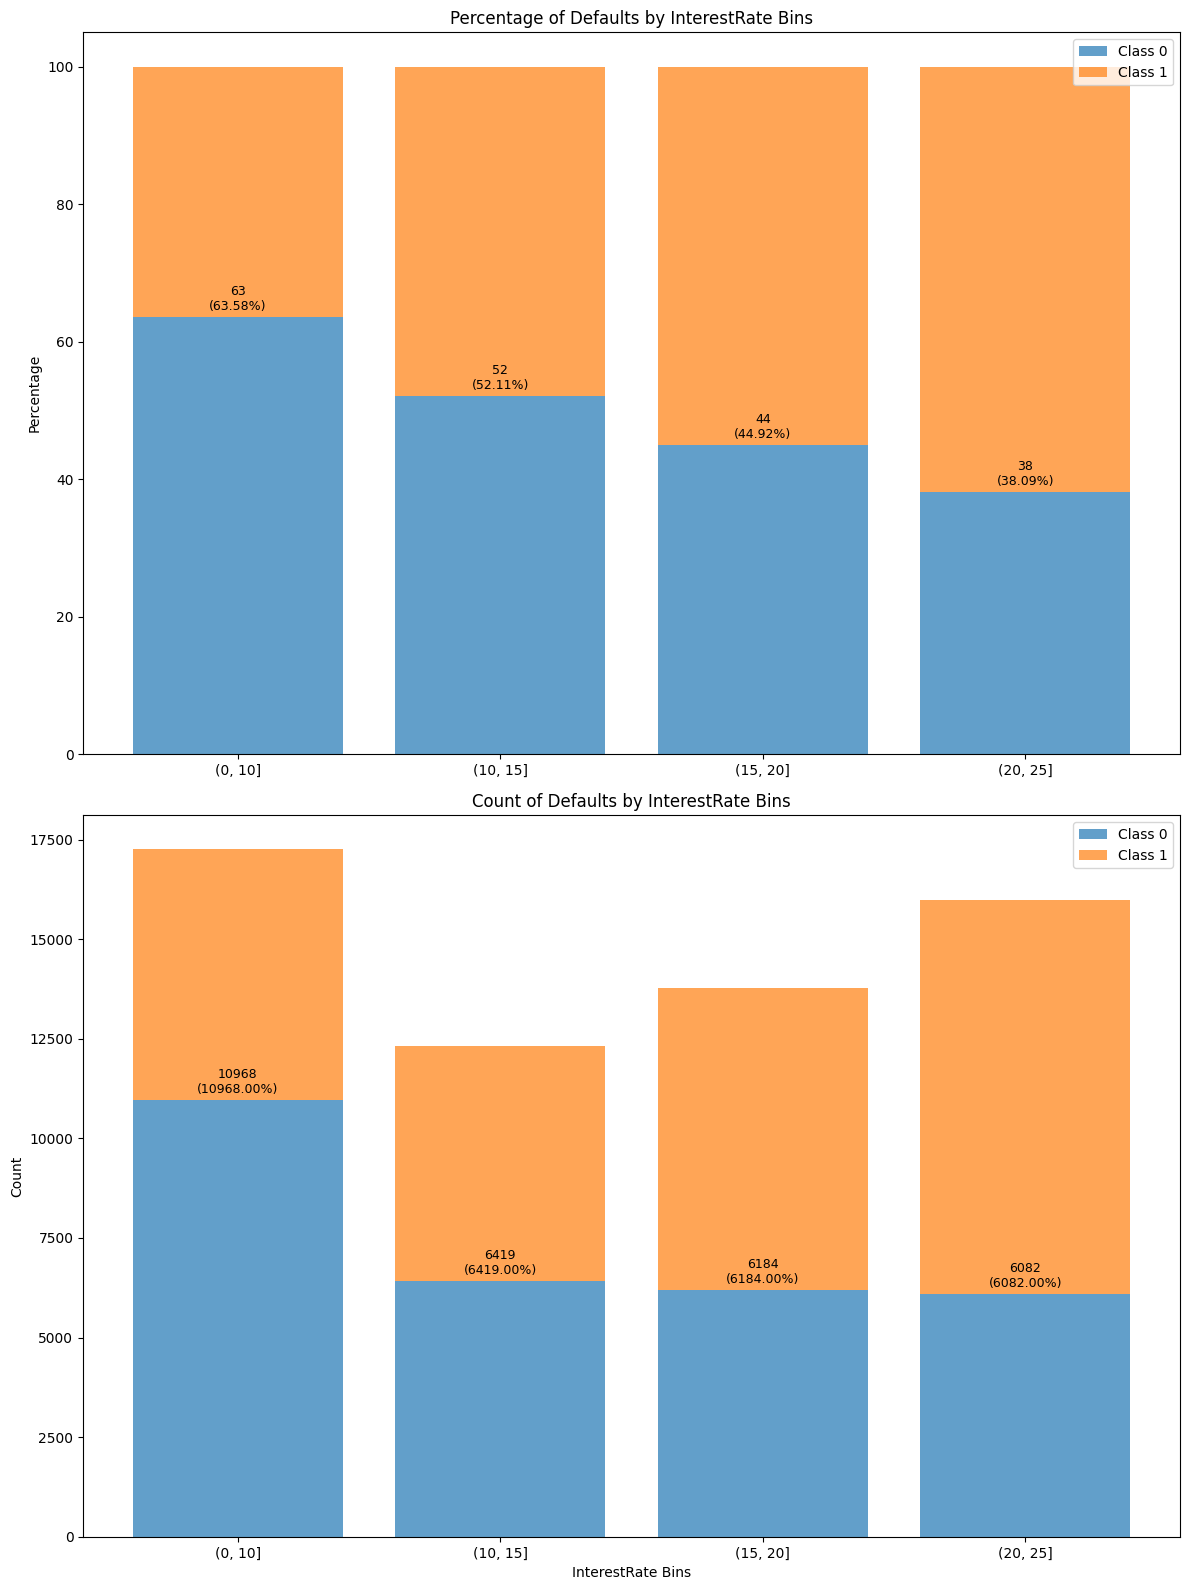

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
interest_rate_bins = [0, 10, 15, 20, 25]
df['InterestRateBin'] = pd.cut(df['InterestRate'], bins=interest_rate_bins)
interest_rate_summary = df.groupby(['InterestRateBin', 'Default'])['Default'].count().unstack().reset_index()
interest_rate_summary['Total'] = interest_rate_summary[0] + interest_rate_summary[1]
interest_rate_summary['Percentage 0'] = (interest_rate_summary[0] / interest_rate_summary['Total']) * 100
interest_rate_summary['Percentage 1'] = (interest_rate_summary[1] / interest_rate_summary['Total']) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Top subplot for percentage
bars1_percentage = ax1.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary['Percentage 0'], label='Class 0', alpha=0.7)
bars2_percentage = ax1.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary['Percentage 1'], label='Class 1', alpha=0.7, bottom=interest_rate_summary['Percentage 0'])
ax1.set_title('Percentage of Defaults by InterestRate Bins')
ax1.set_ylabel('Percentage')
ax1.legend()

# Bottom subplot for count
bars1_count = ax2.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary[0], label='Class 0', alpha=0.7)
bars2_count = ax2.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary[1], label='Class 1', alpha=0.7, bottom=interest_rate_summary[0])
ax2.set_title('Count of Defaults by InterestRate Bins')
ax2.set_xlabel('InterestRate Bins')
ax2.set_ylabel('Count')
ax2.legend()

# Annotate bars with count and percentage
for ax, bars, data_label in zip([ax1, ax2], [bars1_percentage, bars1_count], ['Percentage 0', 0]):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}\n({interest_rate_summary.loc[bars.index(bar), data_label]:.2f}%)',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


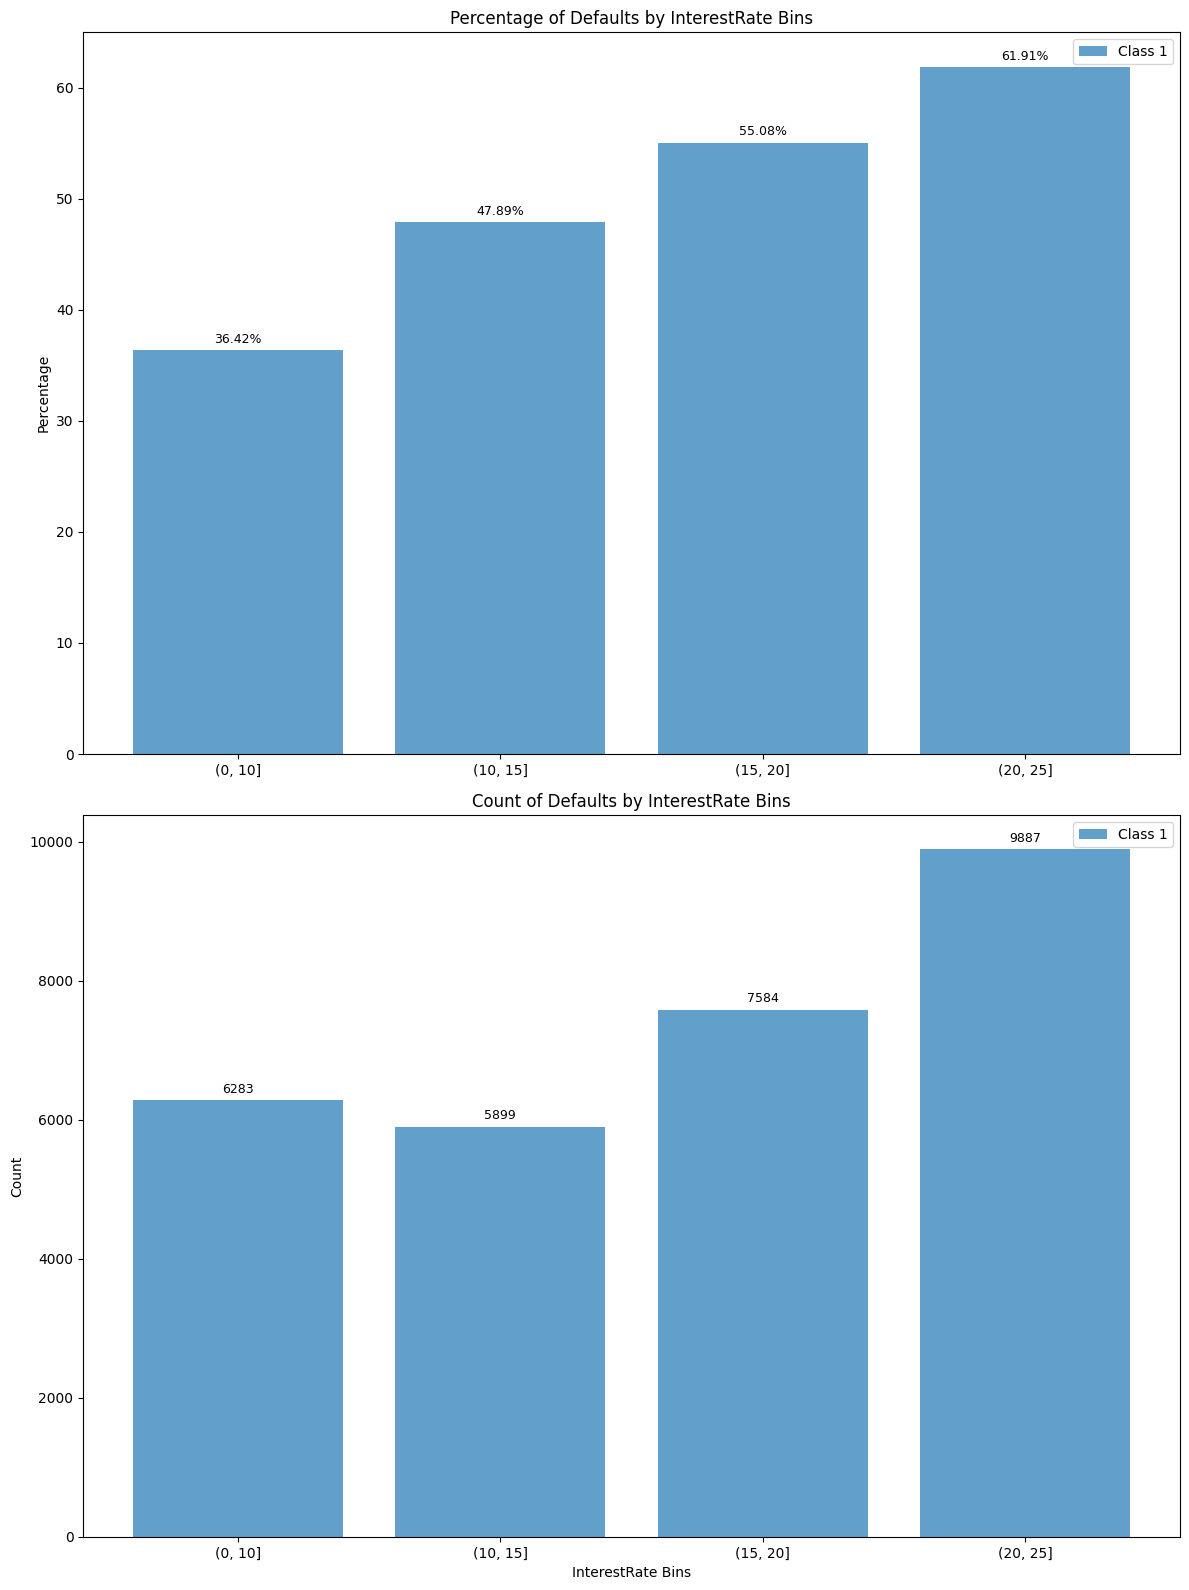

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
interest_rate_bins = [0, 10, 15, 20, 25]
df['InterestRateBin'] = pd.cut(df['InterestRate'], bins=interest_rate_bins)
interest_rate_summary = df.groupby(['InterestRateBin', 'Default'])['Default'].count().unstack().reset_index()
interest_rate_summary['Total'] = interest_rate_summary[0] + interest_rate_summary[1]
interest_rate_summary['Percentage 1'] = (interest_rate_summary[1] / interest_rate_summary['Total']) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Top subplot for percentage
bars_percentage = ax1.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary['Percentage 1'], label='Class 1', alpha=0.7)
ax1.set_title('Percentage of Defaults by InterestRate Bins')
ax1.set_ylabel('Percentage')
ax1.legend()

# Annotate top bars with percentage
for bar, percentage in zip(bars_percentage, interest_rate_summary['Percentage 1']):
    ax1.annotate(f'{percentage:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# Bottom subplot for count
bars_count = ax2.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary[1], label='Class 1', alpha=0.7)
ax2.set_title('Count of Defaults by InterestRate Bins')
ax2.set_xlabel('InterestRate Bins')
ax2.set_ylabel('Count')
ax2.legend()

# Annotate bottom bars with count
for bar in bars_count:
    ax2.annotate(f'{int(bar.get_height())}',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


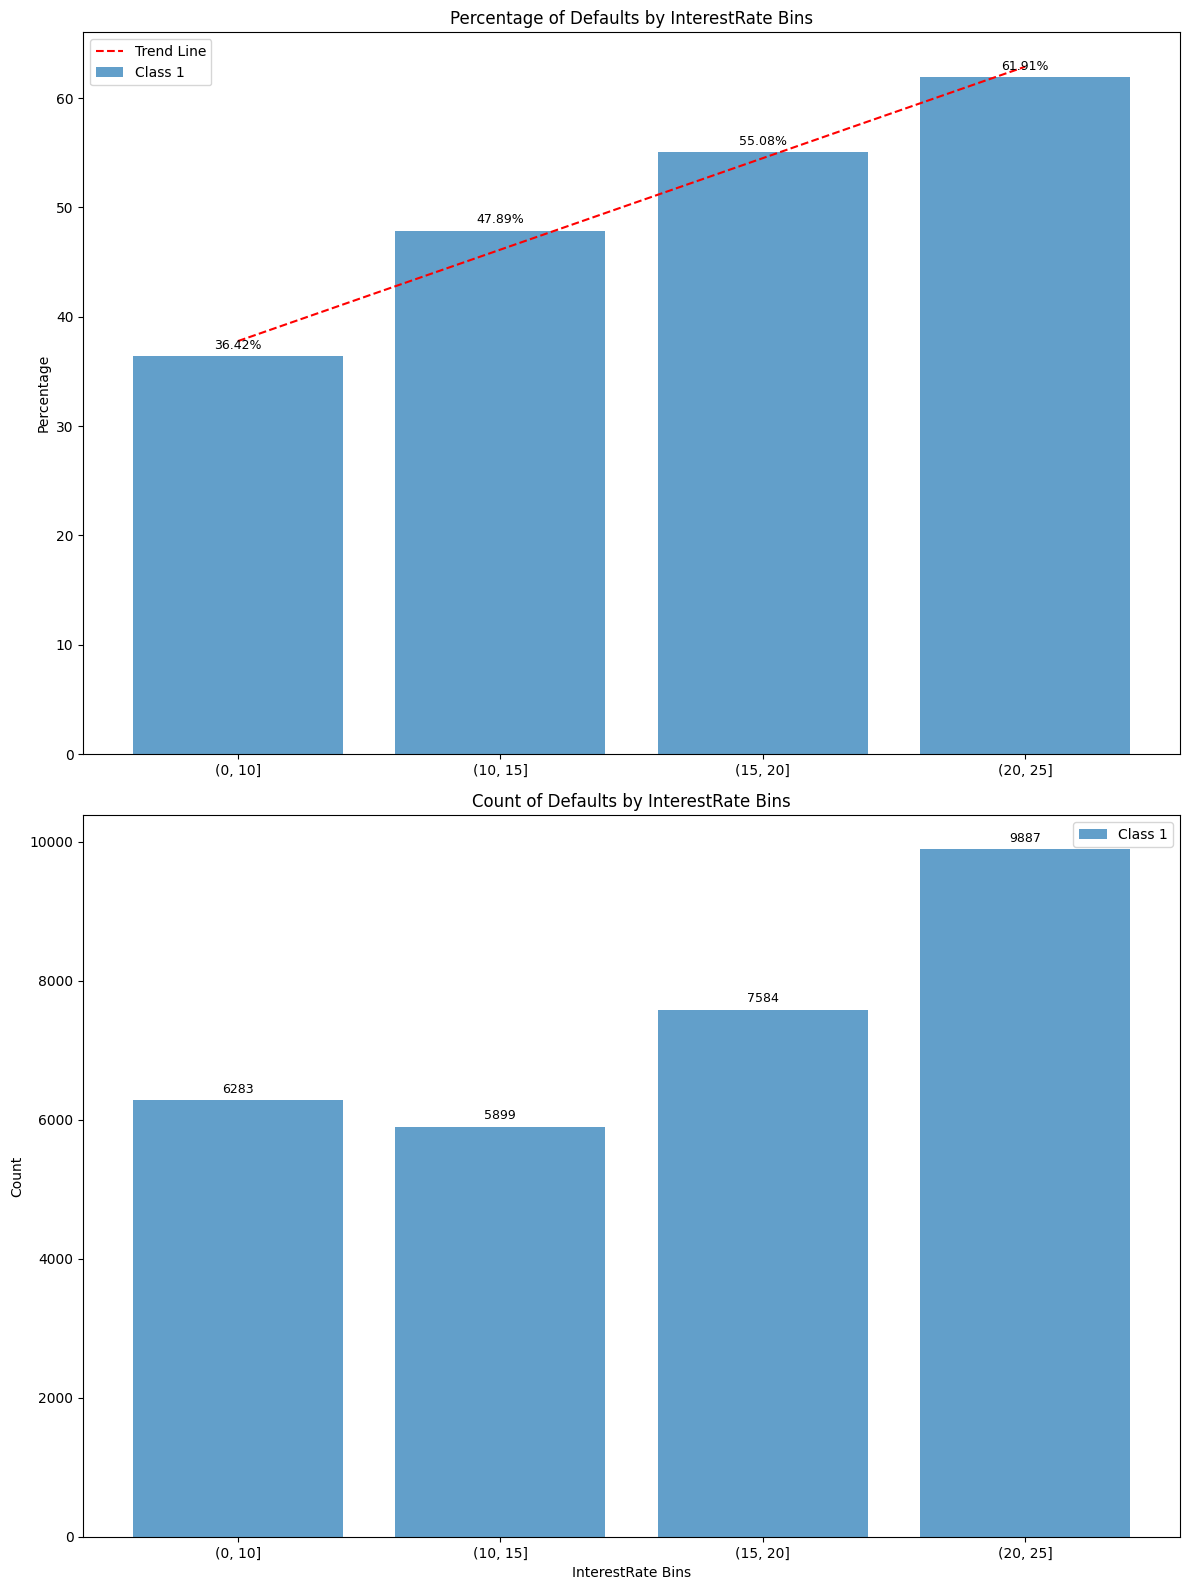

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame and 'InterestRate' and 'Default' are columns in your DataFrame
interest_rate_bins = [0, 10, 15, 20, 25]
df['InterestRateBin'] = pd.cut(df['InterestRate'], bins=interest_rate_bins)
interest_rate_summary = df.groupby(['InterestRateBin', 'Default'])['Default'].count().unstack().reset_index()
interest_rate_summary['Total'] = interest_rate_summary[0] + interest_rate_summary[1]
interest_rate_summary['Percentage 1'] = (interest_rate_summary[1] / interest_rate_summary['Total']) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Top subplot for percentage
bars_percentage = ax1.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary['Percentage 1'], label='Class 1', alpha=0.7)
ax1.set_title('Percentage of Defaults by InterestRate Bins')
ax1.set_ylabel('Percentage')
ax1.legend()

# Fit and plot the trend line for the percentage
z = np.polyfit(range(len(interest_rate_summary)), interest_rate_summary['Percentage 1'], 1)
p = np.poly1d(z)
ax1.plot(interest_rate_summary.InterestRateBin.astype('str'), p(range(len(interest_rate_summary))), "r--", label='Trend Line')
ax1.legend()

# Annotate top bars with percentage
for bar, percentage in zip(bars_percentage, interest_rate_summary['Percentage 1']):
    ax1.annotate(f'{percentage:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# Bottom subplot for count
bars_count = ax2.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary[1], label='Class 1', alpha=0.7)
ax2.set_title('Count of Defaults by InterestRate Bins')
ax2.set_xlabel('InterestRate Bins')
ax2.set_ylabel('Count')
ax2.legend()

# Annotate bottom bars with count
for bar in bars_count:
    ax2.annotate(f'{int(bar.get_height())}',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
interest_rate_summary

Default,InterestRateBin,0,1,Total,Percentage 0,Percentage 1
0,"(0, 10]",10968,6283,17251,63.578923,36.421077
1,"(10, 15]",6419,5899,12318,52.110732,47.889268
2,"(15, 20]",6184,7584,13768,44.915747,55.084253
3,"(20, 25]",6082,9887,15969,38.086292,61.913708


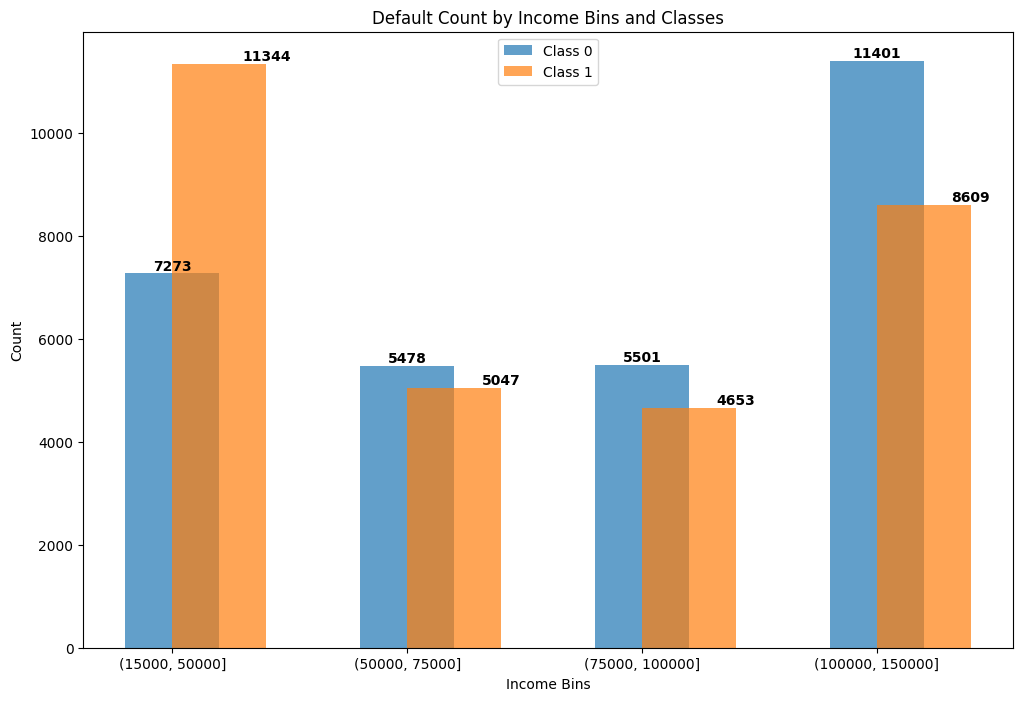

In [ ]:
# Define bin ranges for 'Income'
income_bins = [15000, 50000, 75000, 100000, 150000]

# Apply binning to create a new categorical column
df['IncomeBin'] = pd.cut(df['Income'], bins=income_bins)

# Group by the binned feature and calculate counts for both classes
income_summary = df.groupby(['IncomeBin', 'Default'])['Default'].count().unstack().reset_index()

# Plot the results
plt.figure(figsize=(12, 8))

# Bar chart for class 0
plt.bar(income_summary.IncomeBin.astype('str'), income_summary[0], label='Class 0', alpha=0.7, width=0.4)

# Bar chart for class 1, shifted to the right
plt.bar(income_summary.IncomeBin.astype('str'), income_summary[1], label='Class 1', alpha=0.7, width=0.4, align='edge')

# Add counts on top of the bars
for i, v in enumerate(income_summary[0]):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', color='black', fontweight='bold')

for i, v in enumerate(income_summary[1]):
    plt.text(i + 0.4, v + 10, str(v), ha='center', va='bottom', color='black', fontweight='bold')

# Add labels and legend
plt.title('Default Count by Income Bins and Classes')
plt.xlabel('Income Bins')
plt.ylabel('Count')
plt.legend()

plt.show()


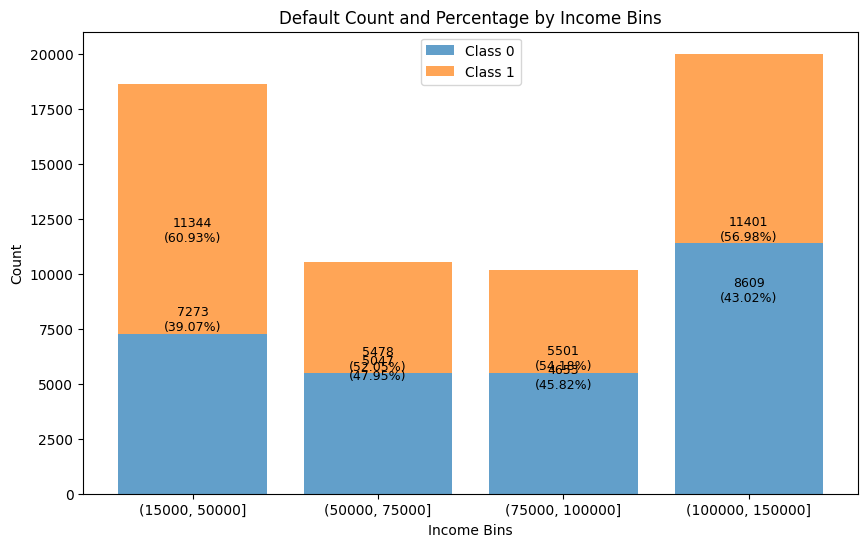

In [ ]:
# Define bin ranges for 'Income'
income_bins = [15000, 50000, 75000, 100000, 150000]

# Apply binning to create a new categorical column
df['IncomeBin'] = pd.cut(df['Income'], bins=income_bins)

# Group by the binned feature and calculate counts for both classes
income_summary = df.groupby(['IncomeBin', 'Default'])['Default'].count().unstack().reset_index()

# Calculate the total count for each bin
income_summary['Total'] = income_summary[0] + income_summary[1]

# Calculate the percentage for each class
income_summary['Percentage 0'] = (income_summary[0] / income_summary['Total']) * 100
income_summary['Percentage 1'] = (income_summary[1] / income_summary['Total']) * 100

# Plot the results
plt.figure(figsize=(10, 6))

# Plot bar chart for class 0
bars1 = plt.bar(income_summary.IncomeBin.astype('str'), income_summary[0], label='Class 0', alpha=0.7)

# Plot bar chart for class 1
bars2 = plt.bar(income_summary.IncomeBin.astype('str'), income_summary[1], label='Class 1', alpha=0.7, bottom=income_summary[0])

# Annotate bars with count and percentage
for bars, percentage in zip([bars1, bars2], ['Percentage 0', 'Percentage 1']):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{int(yval)}\n({income_summary.loc[bars.index(bar), percentage]:.2f}%)', va='bottom', ha='center', fontsize=9)

plt.title('Default Count and Percentage by Income Bins')
plt.xlabel('Income Bins')
plt.ylabel('Count')
plt.legend()

plt.show()


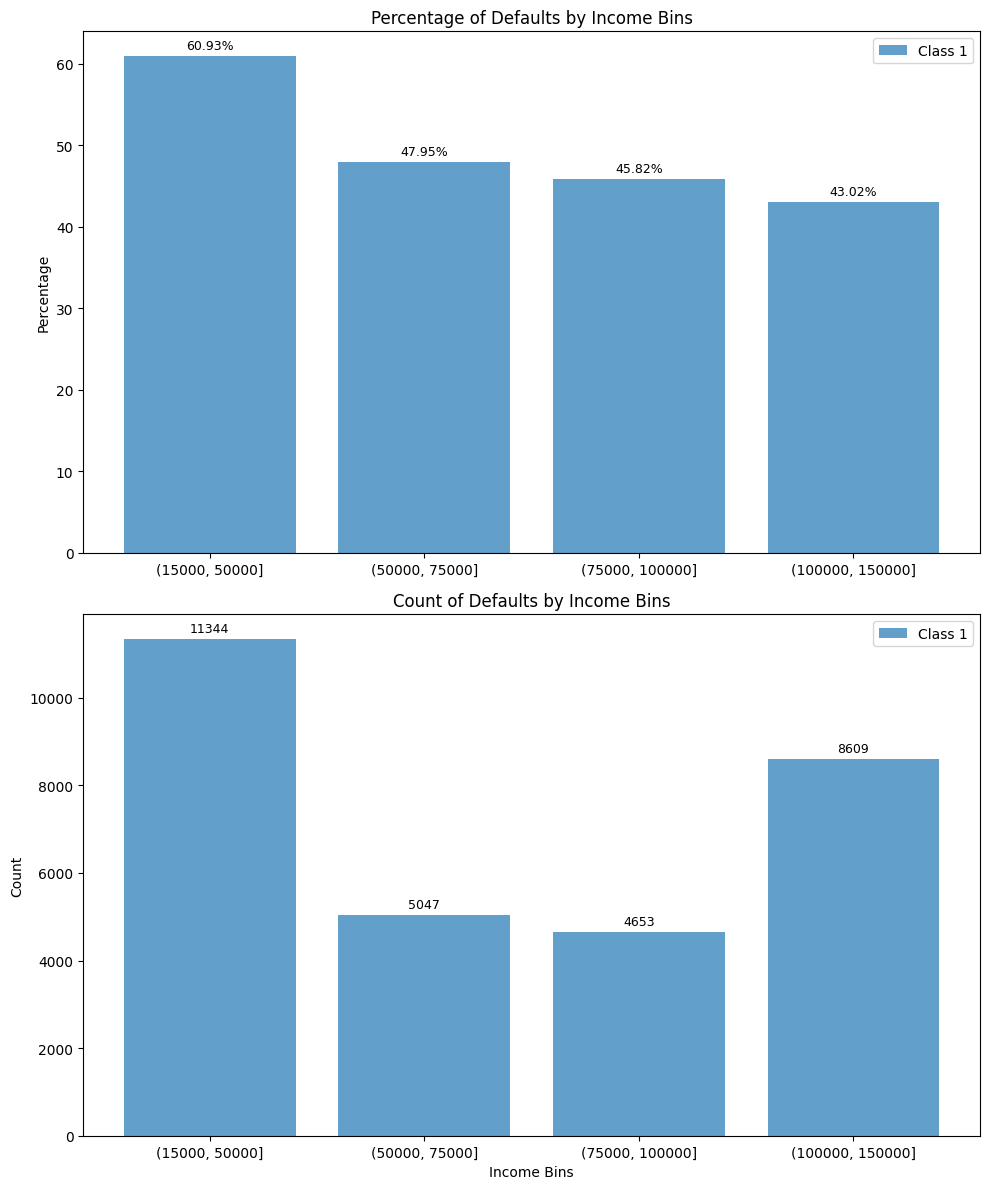

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'Income' and 'Default' are columns in your DataFrame
income_bins = [15000, 50000, 75000, 100000, 150000]
df['IncomeBin'] = pd.cut(df['Income'], bins=income_bins)
income_summary = df.groupby(['IncomeBin', 'Default'])['Default'].count().unstack().reset_index()
income_summary['Total'] = income_summary[0] + income_summary[1]
income_summary['Percentage 1'] = (income_summary[1] / income_summary['Total']) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Top subplot for percentage
bars_percentage = ax1.bar(income_summary.IncomeBin.astype('str'), income_summary['Percentage 1'], label='Class 1', alpha=0.7)
ax1.set_title('Percentage of Defaults by Income Bins')
ax1.set_ylabel('Percentage')
ax1.legend()

# Annotate top bars with percentage
for bar, percentage in zip(bars_percentage, income_summary['Percentage 1']):
    ax1.annotate(f'{percentage:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# Bottom subplot for count
bars_count = ax2.bar(income_summary.IncomeBin.astype('str'), income_summary[1], label='Class 1', alpha=0.7)
ax2.set_title('Count of Defaults by Income Bins')
ax2.set_xlabel('Income Bins')
ax2.set_ylabel('Count')
ax2.legend()

# Annotate bottom bars with count
for bar in bars_count:
    ax2.annotate(f'{int(bar.get_height())}',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()




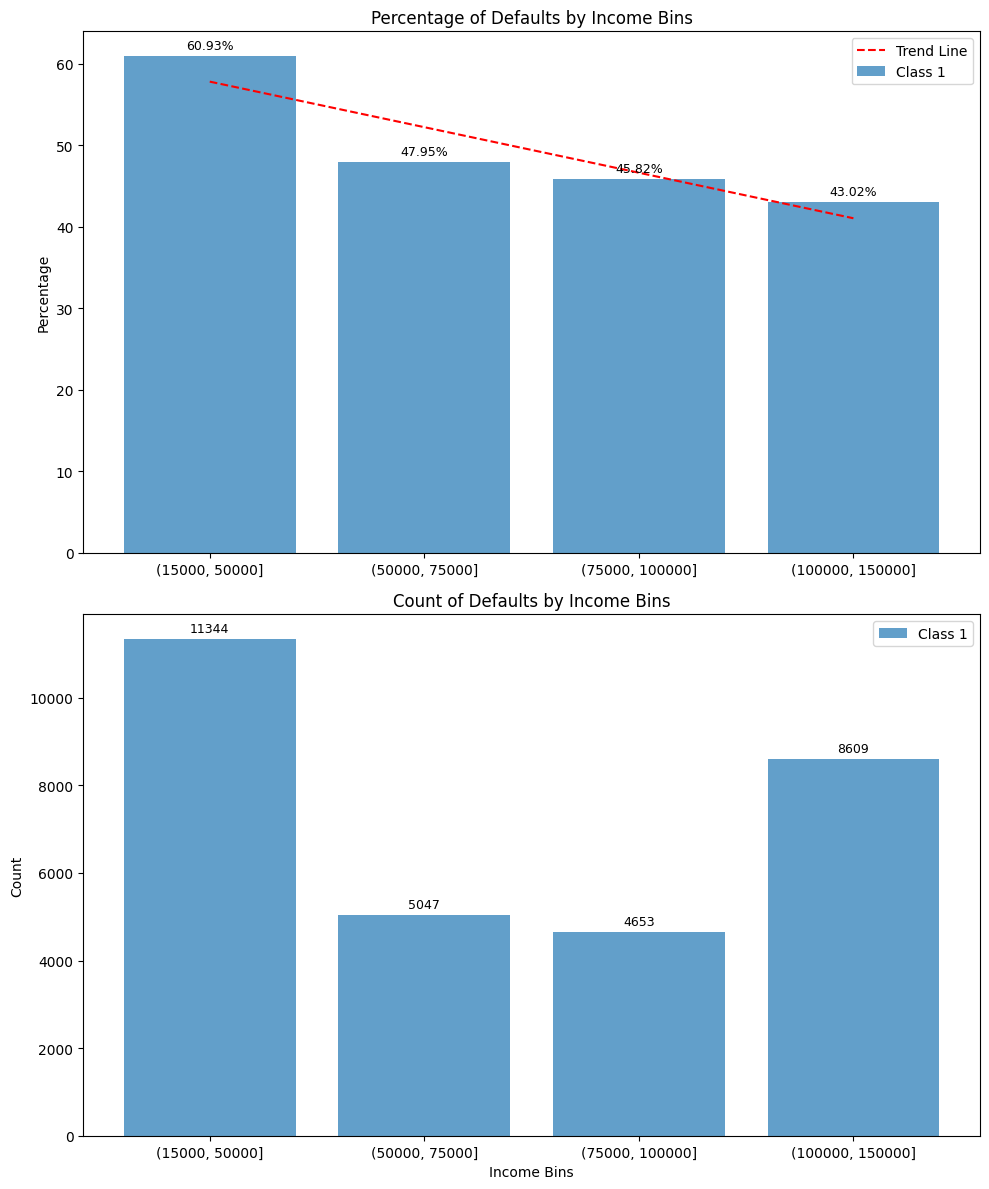

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame and 'Income' and 'Default' are columns in your DataFrame
income_bins = [15000, 50000, 75000, 100000, 150000]
df['IncomeBin'] = pd.cut(df['Income'], bins=income_bins)
income_summary = df.groupby(['IncomeBin', 'Default'])['Default'].count().unstack().reset_index()
income_summary['Total'] = income_summary[0] + income_summary[1]
income_summary['Percentage 1'] = (income_summary[1] / income_summary['Total']) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Top subplot for percentage
bars_percentage = ax1.bar(income_summary.IncomeBin.astype('str'), income_summary['Percentage 1'], label='Class 1', alpha=0.7)
ax1.set_title('Percentage of Defaults by Income Bins')
ax1.set_ylabel('Percentage')
ax1.legend()

# Fit and plot the trend line for the percentage
z = np.polyfit(range(len(income_summary)), income_summary['Percentage 1'], 1)
p = np.poly1d(z)
ax1.plot(income_summary.IncomeBin.astype('str'), p(range(len(income_summary))), "r--", label='Trend Line')
ax1.legend()

# Annotate top bars with percentage
for bar, percentage in zip(bars_percentage, income_summary['Percentage 1']):
    ax1.annotate(f'{percentage:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# Bottom subplot for count
bars_count = ax2.bar(income_summary.IncomeBin.astype('str'), income_summary[1], label='Class 1', alpha=0.7)
ax2.set_title('Count of Defaults by Income Bins')
ax2.set_xlabel('Income Bins')
ax2.set_ylabel('Count')
ax2.legend()

# Annotate bottom bars with count
for bar in bars_count:
    ax2.annotate(f'{int(bar.get_height())}',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



In [ ]:
income_summary

Default,IncomeBin,0,1,Total,Percentage 0,Percentage 1
0,"(15000, 50000]",7273,11344,18617,39.066445,60.933555
1,"(50000, 75000]",5478,5047,10525,52.047506,47.952494
2,"(75000, 100000]",5501,4653,10154,54.175694,45.824306
3,"(100000, 150000]",11401,8609,20010,56.976512,43.023488


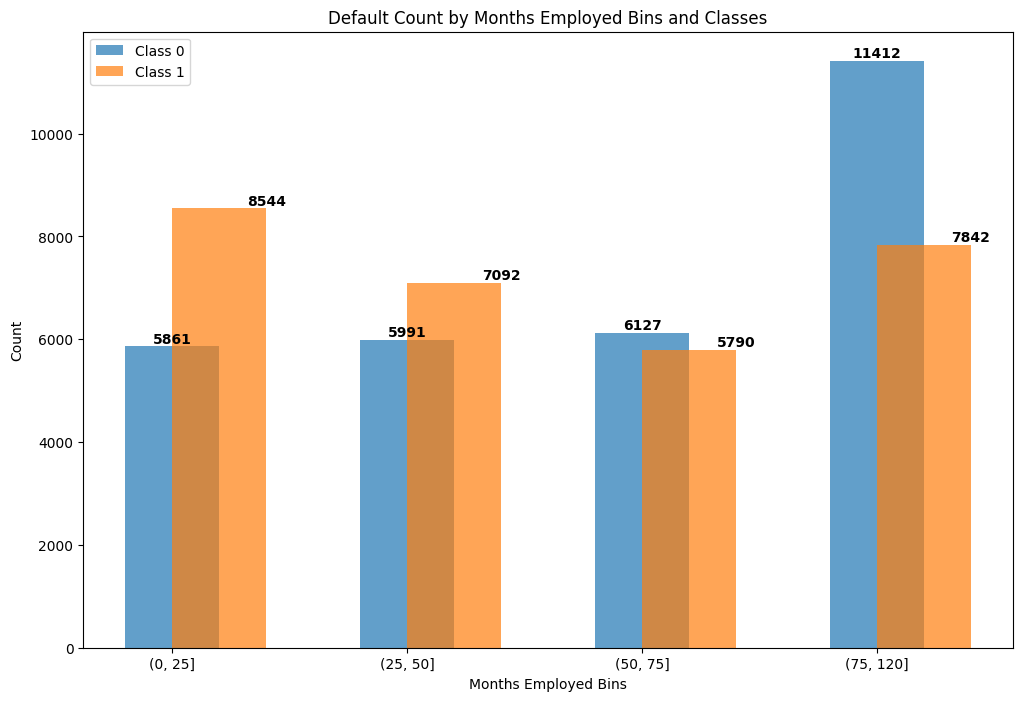

In [ ]:
# Define bin ranges for 'MonthsEmployed'
employed_bins = [0, 25, 50, 75, 120]

# Apply binning to create a new categorical column
df['MonthsEmployedBin'] = pd.cut(df['MonthsEmployed'], bins=employed_bins)

# Group by the binned feature and calculate counts for both classes
employed_summary = df.groupby(['MonthsEmployedBin', 'Default'])['Default'].count().unstack().reset_index()

# Plot the results
plt.figure(figsize=(12, 8))

# Bar chart for class 0
plt.bar(employed_summary.MonthsEmployedBin.astype('str'), employed_summary[0], label='Class 0', alpha=0.7, width=0.4)

# Bar chart for class 1, shifted to the right
plt.bar(employed_summary.MonthsEmployedBin.astype('str'), employed_summary[1], label='Class 1', alpha=0.7, width=0.4, align='edge')

# Add counts on top of the bars
for i, v in enumerate(employed_summary[0]):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', color='black', fontweight='bold')

for i, v in enumerate(employed_summary[1]):
    plt.text(i + 0.4, v + 10, str(v), ha='center', va='bottom', color='black', fontweight='bold')

# Add labels and legend
plt.title('Default Count by Months Employed Bins and Classes')
plt.xlabel('Months Employed Bins')
plt.ylabel('Count')
plt.legend()

plt.show()


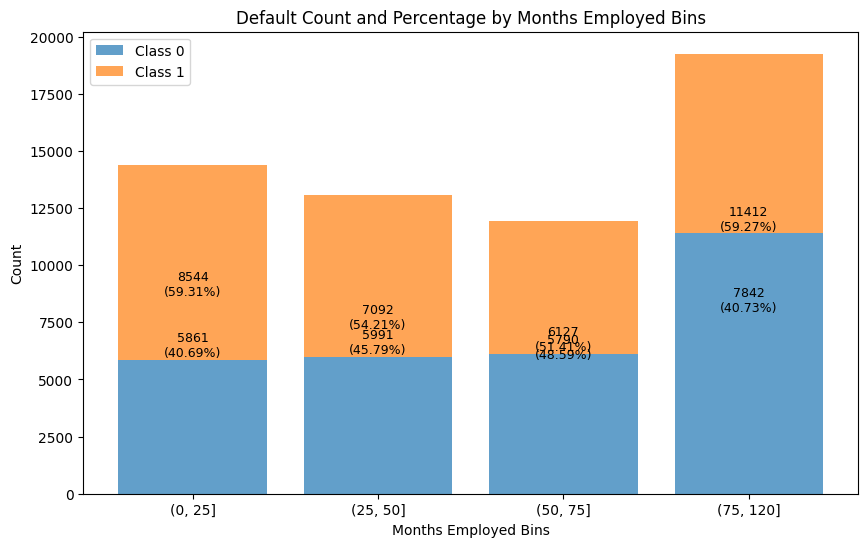

In [ ]:
# Define bin ranges for 'MonthsEmployed'
employed_bins = [0, 25, 50, 75, 120]

# Apply binning to create a new categorical column
df['MonthsEmployedBin'] = pd.cut(df['MonthsEmployed'], bins=employed_bins)

# Group by the binned feature and calculate counts for both classes
employed_summary = df.groupby(['MonthsEmployedBin', 'Default'])['Default'].count().unstack().reset_index()

# Calculate the total count for each bin
employed_summary['Total'] = employed_summary[0] + employed_summary[1]

# Calculate the percentage for each class
employed_summary['Percentage 0'] = (employed_summary[0] / employed_summary['Total']) * 100
employed_summary['Percentage 1'] = (employed_summary[1] / employed_summary['Total']) * 100

# Plot the results
plt.figure(figsize=(10, 6))

# Plot bar chart for class 0
bars1 = plt.bar(employed_summary.MonthsEmployedBin.astype('str'), employed_summary[0], label='Class 0', alpha=0.7)

# Plot bar chart for class 1
bars2 = plt.bar(employed_summary.MonthsEmployedBin.astype('str'), employed_summary[1], label='Class 1', alpha=0.7, bottom=employed_summary[0])

# Annotate bars with count and percentage
for bars, percentage in zip([bars1, bars2], ['Percentage 0', 'Percentage 1']):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{int(yval)}\n({employed_summary.loc[bars.index(bar), percentage]:.2f}%)', va='bottom', ha='center', fontsize=9)

plt.title('Default Count and Percentage by Months Employed Bins')
plt.xlabel('Months Employed Bins')
plt.ylabel('Count')
plt.legend()

plt.show()


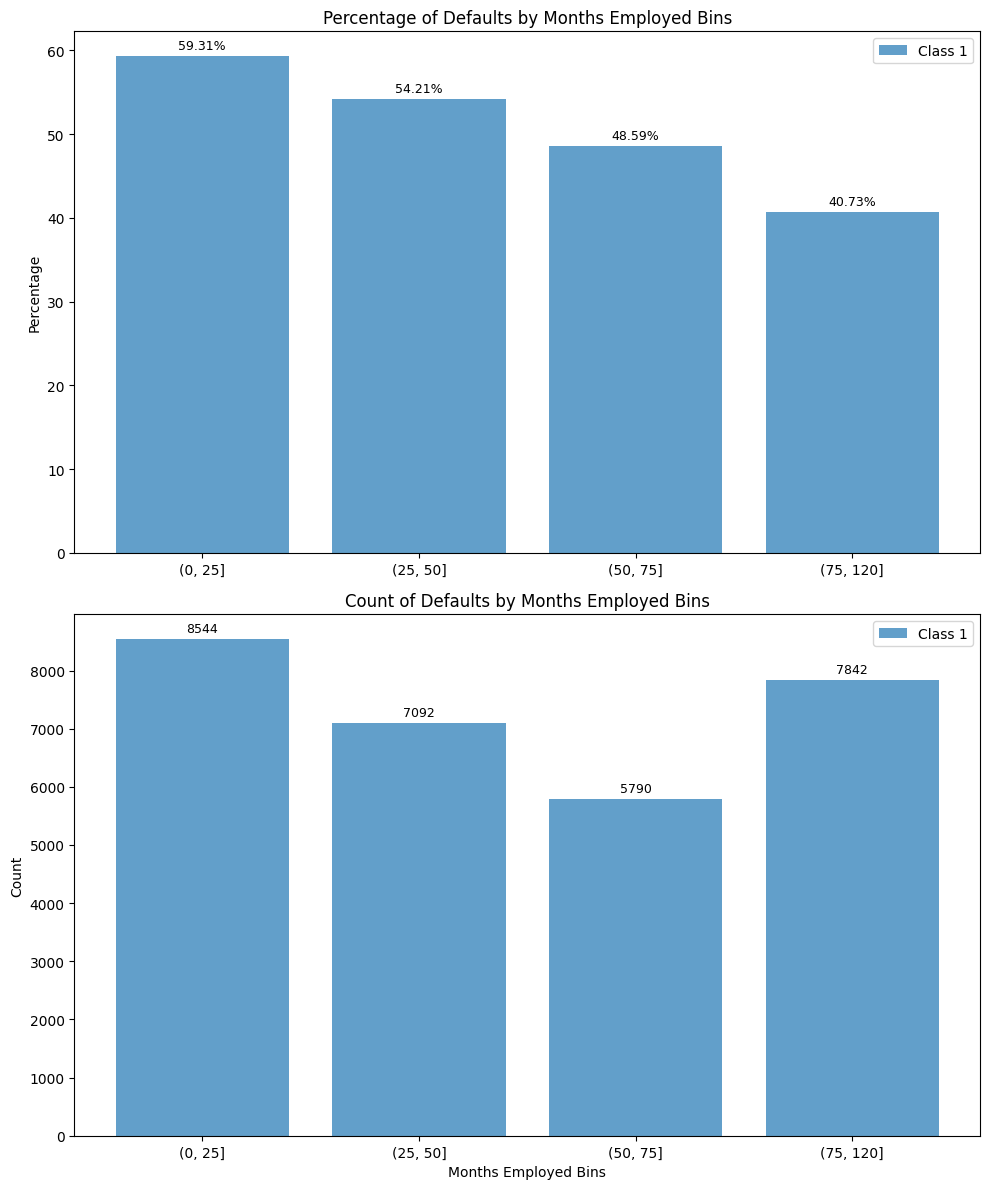

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'MonthsEmployed' and 'Default' are columns in your DataFrame
employed_bins = [0, 25, 50, 75, 120]
df['MonthsEmployedBin'] = pd.cut(df['MonthsEmployed'], bins=employed_bins)
employed_summary = df.groupby(['MonthsEmployedBin', 'Default'])['Default'].count().unstack().reset_index()
employed_summary['Total'] = employed_summary[0] + employed_summary[1]
employed_summary['Percentage 1'] = (employed_summary[1] / employed_summary['Total']) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Top subplot for percentage
bars_percentage = ax1.bar(employed_summary.MonthsEmployedBin.astype('str'), employed_summary['Percentage 1'], label='Class 1', alpha=0.7)
ax1.set_title('Percentage of Defaults by Months Employed Bins')
ax1.set_ylabel('Percentage')
ax1.legend()

# Annotate top bars with percentage
for bar, percentage in zip(bars_percentage, employed_summary['Percentage 1']):
    ax1.annotate(f'{percentage:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# Bottom subplot for count
bars_count = ax2.bar(employed_summary.MonthsEmployedBin.astype('str'), employed_summary[1], label='Class 1', alpha=0.7)
ax2.set_title('Count of Defaults by Months Employed Bins')
ax2.set_xlabel('Months Employed Bins')
ax2.set_ylabel('Count')
ax2.legend()

# Annotate bottom bars with count
for bar in bars_count:
    ax2.annotate(f'{int(bar.get_height())}',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()




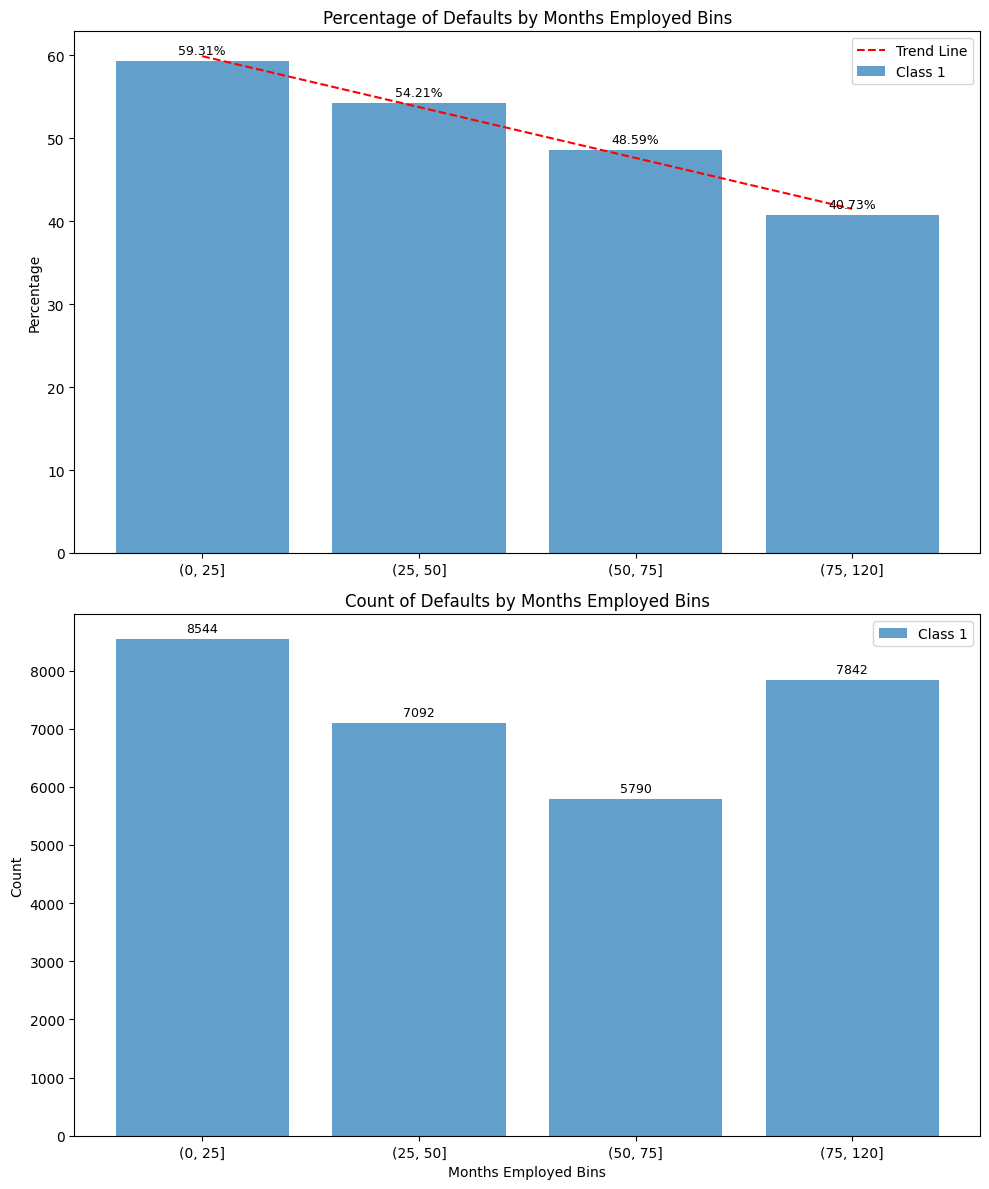

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame and 'MonthsEmployed' and 'Default' are columns in your DataFrame
employed_bins = [0, 25, 50, 75, 120]
df['MonthsEmployedBin'] = pd.cut(df['MonthsEmployed'], bins=employed_bins)
employed_summary = df.groupby(['MonthsEmployedBin', 'Default'])['Default'].count().unstack().reset_index()
employed_summary['Total'] = employed_summary[0] + employed_summary[1]
employed_summary['Percentage 1'] = (employed_summary[1] / employed_summary['Total']) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Top subplot for percentage
bars_percentage = ax1.bar(employed_summary.MonthsEmployedBin.astype('str'), employed_summary['Percentage 1'], label='Class 1', alpha=0.7)
ax1.set_title('Percentage of Defaults by Months Employed Bins')
ax1.set_ylabel('Percentage')
ax1.legend()

# Fit and plot the trend line for the percentage
z = np.polyfit(range(len(employed_summary)), employed_summary['Percentage 1'], 1)
p = np.poly1d(z)
ax1.plot(employed_summary.MonthsEmployedBin.astype('str'), p(range(len(employed_summary))), "r--", label='Trend Line')
ax1.legend()

# Annotate top bars with percentage
for bar, percentage in zip(bars_percentage, employed_summary['Percentage 1']):
    ax1.annotate(f'{percentage:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# Bottom subplot for count
bars_count = ax2.bar(employed_summary.MonthsEmployedBin.astype('str'), employed_summary[1], label='Class 1', alpha=0.7)
ax2.set_title('Count of Defaults by Months Employed Bins')
ax2.set_xlabel('Months Employed Bins')
ax2.set_ylabel('Count')
ax2.legend()

# Annotate bottom bars with count
for bar in bars_count:
    ax2.annotate(f'{int(bar.get_height())}',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



In [ ]:
employed_summary

Default,MonthsEmployedBin,0,1,Total,Percentage 0,Percentage 1
0,"(0, 25]",5861,8544,14405,40.687261,59.312739
1,"(25, 50]",5991,7092,13083,45.792249,54.207751
2,"(50, 75]",6127,5790,11917,51.413946,48.586054
3,"(75, 120]",11412,7842,19254,59.270801,40.729199


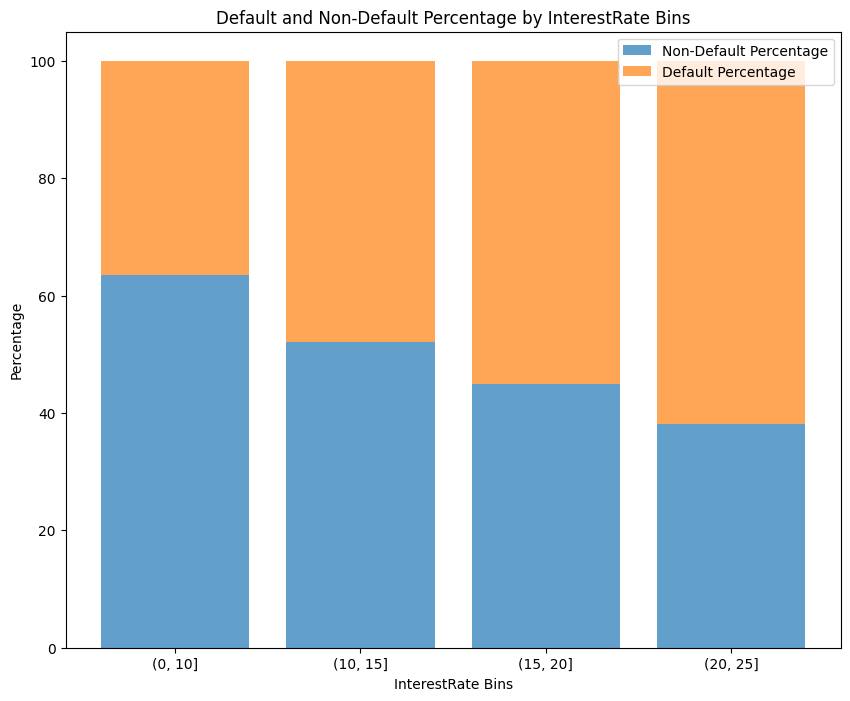

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'Default' is your target variable
interest_rate_bins = [0, 10, 15, 20, 25]

# Apply binning to create a new categorical column
df['InterestRateBin'] = pd.cut(df['InterestRate'], bins=interest_rate_bins)

# Group by the binned feature and calculate the count for both classes
interest_rate_summary = df.groupby(['InterestRateBin', 'Default'])['Default'].count().unstack().reset_index()

# Calculate the total count for each bin
interest_rate_summary['Total'] = interest_rate_summary[0] + interest_rate_summary[1]

# Calculate the default rate and percentage for each bin
interest_rate_summary['DefaultRate'] = interest_rate_summary[1] / interest_rate_summary['Total']
interest_rate_summary['NonDefaultPercentage'] = (interest_rate_summary[0] / interest_rate_summary['Total']) * 100
interest_rate_summary['DefaultPercentage'] = (interest_rate_summary[1] / interest_rate_summary['Total']) * 100

# Plot the results with percentage
plt.figure(figsize=(10, 8))

# Bar chart for Non-Default Percentage
plt.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary['NonDefaultPercentage'], label='Non-Default Percentage', alpha=0.7)

# Bar chart for Default Percentage on top of the previous one
plt.bar(interest_rate_summary.InterestRateBin.astype('str'), interest_rate_summary['DefaultPercentage'], bottom=interest_rate_summary['NonDefaultPercentage'], label='Default Percentage', alpha=0.7)

# Add labels and legend
plt.title('Default and Non-Default Percentage by InterestRate Bins')
plt.xlabel('InterestRate Bins')
plt.ylabel('Percentage')
plt.legend()

plt.show()


# Optimized Boosted Tree

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
param_grid = {'n_estimators': [50, 100, 150, 200]}
grid_search = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(train_X, train_y)

best_ada_boost_clf = grid_search.best_estimator_

# Fitting the model on the training data
best_ada_boost_clf.fit(train_X, train_y)

# Predicting on the validation data
y_pred_ada = best_ada_boost_clf.predict(valid_X)

# Calculating accuracy
accuracy = accuracy_score(valid_y, y_pred_ada)
print(f"Accuracy: {accuracy}")

# Generating a classification report
print(classification_report(valid_y, y_pred_ada))

# Generating and print confusion matrix
conf_matrix = confusion_matrix(valid_y, y_pred_ada)
print("Confusion Matrix:")
print(conf_matrix)

# ROC AUC
print('ROC AUC: ', roc_auc_score(valid_y, best_ada_boost_clf.predict_proba(valid_X)[:,1]))


Accuracy: 0.6857014388489209
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      8999
           1       0.68      0.70      0.69      8793

    accuracy                           0.69     17792
   macro avg       0.69      0.69      0.69     17792
weighted avg       0.69      0.69      0.69     17792

Confusion Matrix:
[[6027 2972]
 [2620 6173]]
ROC AUC:  0.7532042524355442


# Feature Selection For Optimized Model

We took one of the features (MonthsEmployed) to see if the optimized model would have an effect on the classes on their rate and count, but the results remained the same.

Accuracy: 0.6857014388489209
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      8999
           1       0.68      0.70      0.69      8793

    accuracy                           0.69     17792
   macro avg       0.69      0.69      0.69     17792
weighted avg       0.69      0.69      0.69     17792

Confusion Matrix:
[[6027 2972]
 [2620 6173]]
ROC AUC:  0.7532042524355442


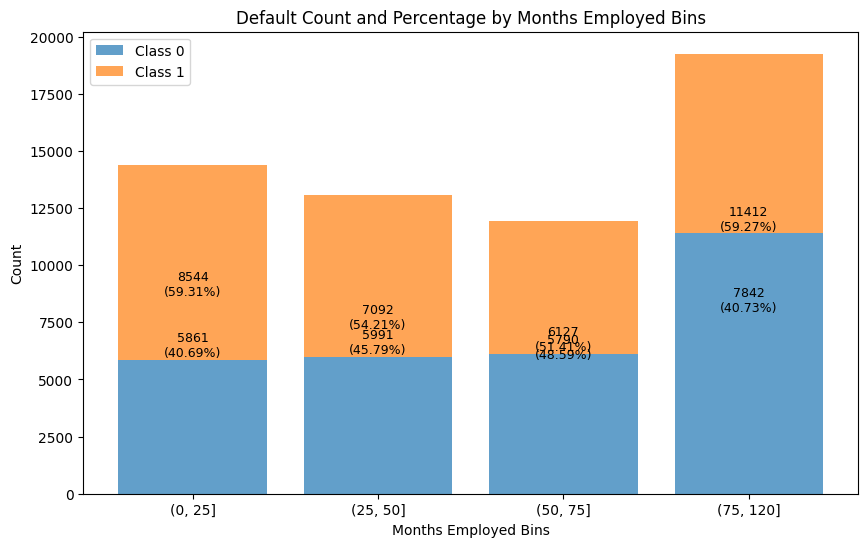

In [ ]:
# Define bin ranges for 'MonthsEmployed'
employed_bins = [0, 25, 50, 75, 120]

# Apply binning to create a new categorical column
df['MonthsEmployedBin'] = pd.cut(df['MonthsEmployed'], bins=employed_bins)

# Group by the binned feature and calculate counts for both classes
employed_summary = df.groupby(['MonthsEmployedBin', 'Default'])['Default'].count().unstack().reset_index()

# Calculate the total count for each bin
employed_summary['Total'] = employed_summary[0] + employed_summary[1]

# Calculate the percentage for each class
employed_summary['Percentage 0'] = (employed_summary[0] / employed_summary['Total']) * 100
employed_summary['Percentage 1'] = (employed_summary[1] / employed_summary['Total']) * 100

# Plot the results
plt.figure(figsize=(10, 6))

# Plot bar chart for class 0
bars1 = plt.bar(employed_summary.MonthsEmployedBin.astype('str'), employed_summary[0], label='Class 0', alpha=0.7)

# Plot bar chart for class 1
bars2 = plt.bar(employed_summary.MonthsEmployedBin.astype('str'), employed_summary[1], label='Class 1', alpha=0.7, bottom=employed_summary[0])

# Annotate bars with count and percentage
for bars, percentage in zip([bars1, bars2], ['Percentage 0', 'Percentage 1']):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{int(yval)}\n({employed_summary.loc[bars.index(bar), percentage]:.2f}%)', va='bottom', ha='center', fontsize=9)

plt.title('Default Count and Percentage by Months Employed Bins')
plt.xlabel('Months Employed Bins')
plt.ylabel('Count')
plt.legend()

# Using the optimized AdaBoost model
# Assuming best_ada_boost_clf is already defined in your code

# Predicting on the validation data
y_pred_ada = best_ada_boost_clf.predict(valid_X)

# Calculating accuracy
accuracy = accuracy_score(valid_y, y_pred_ada)
print(f"Accuracy: {accuracy}")

# Generating a classification report
print(classification_report(valid_y, y_pred_ada))

# Generating and print confusion matrix
conf_matrix = confusion_matrix(valid_y, y_pred_ada)
print("Confusion Matrix:")
print(conf_matrix)

# ROC AUC
print('ROC AUC: ', roc_auc_score(valid_y, best_ada_boost_clf.predict_proba(valid_X)[:,1]))

plt.show()


# XBG Boost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xg_clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3,
                           learning_rate = 0.1, max_depth = 5, reg_alpha = 10,
                           n_estimators = 100, use_label_encoder=False, eval_metric='logloss')

# Fitting the classifier to the training data
xg_clf.fit(train_X, train_y)

# Predicting the labels of the validation set
y_pred_xg = xg_clf.predict(valid_X)


In [ ]:
import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=X_dummies, label=y)


In [ ]:
params = {
    "objective": "binary:logistic",
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10
}

cv_results = xgb.cv(
    dtrain=data_dmatrix,
    params=params,
    nfold=3,
    num_boost_round=50,
    early_stopping_rounds=10,
    metrics="auc",
    as_pandas=True,
    seed=123
)


In [ ]:
cv_results.head()


In [ ]:
params = {
    "objective": "binary:logistic",
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10
}

# Train the model
xg_clf = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)


In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

# Set the size of the figure
plt.figure(figsize=(20, 20))

plot_tree(xg_clf, num_trees=1)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Set the size of the plot
plt.figure(figsize=(10, 10))

# Plot feature importance
# Replace 'xg_reg' with 'xg_clf' if that's your model's variable name
plot_importance(xg_clf)

plt.rcParams['font.size'] = 12  # Optional: Adjust font size here

# Show plot
plt.show()


In [ ]:
# Convert the validation set into DMatrix first
valid_dmatrix = xgb.DMatrix(data=valid_X, label=valid_y)

# Predict the labels of the validation set using the native API
y_pred_xg = xg_clf.predict(valid_dmatrix)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming valid_dmatrix is the DMatrix for your validation data
y_pred_prob = xg_clf.predict(valid_dmatrix)

# Typically, a threshold of 0.5 is used for binary classification so that's what we are going to use
y_pred_xg = [1 if y_prob > 0.5 else 0 for y_prob in y_pred_prob]

# Calculate accuracy
accuracy = accuracy_score(valid_y, y_pred_xg)
print(f"Accuracy: {accuracy}")

# Generate a classification report
print(classification_report(valid_y, y_pred_xg))

# Generate and print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(valid_y, y_pred_xg))


In [ ]:
from sklearn.metrics import roc_auc_score

# Convert the validation set into DMatrix first
valid_dmatrix = xgb.DMatrix(data=valid_X, label=valid_y)

# Predict the probability of the positive class
y_pred_prob = xg_clf.predict(valid_dmatrix)

# Calculate the ROC AUC score
roc_auc_xg = roc_auc_score(valid_y, y_pred_prob)

print('ROC AUC for XGBoost:', roc_auc_xg)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convert the validation set into DMatrix first
valid_dmatrix = xgb.DMatrix(data=valid_X, label=valid_y)

# Predict the probability of the positive class
y_pred_prob = xg_clf.predict(valid_dmatrix)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(valid_y, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming xg_clf is your trained XGBoost model
xg_roc_auc = roc_auc_score(valid_y, xg_clf.predict(valid_dmatrix))
xg_fpr, xg_tpr, xg_thresholds = roc_curve(valid_y, xg_clf.predict(valid_dmatrix))

plt.figure(figsize=(8, 8))
plt.plot(xg_fpr, xg_tpr, label='XGBoost (area = %0.2f)' % xg_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for XGBoost')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC')
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(max_depth=5, random_state=0)
rf_model.fit(train_X, train_y)

# Predicting on the validation data
y_pred_rf = rf_model.predict(valid_X)


In [ ]:
conf_matrix_rf = confusion_matrix(valid_y, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

Confusion Matrix:
[[5918 3081]
 [2684 6109]]


In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(valid_y, y_pred_rf))


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.67      8999
           1       0.66      0.69      0.68      8793

    accuracy                           0.68     17792
   macro avg       0.68      0.68      0.68     17792
weighted avg       0.68      0.68      0.68     17792



In [ ]:
# Random Forest - Randomized Search Model
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}


In [ ]:
# Use a more modest value for n_iter (e.g., 20)
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(train_X, train_y)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
print(classification_report(valid_y, rf_random.predict(valid_X)))

In [ ]:
# Predicting on the validation data
y_pred_rf_randomized = rf_random.predict(valid_X)


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(valid_y, y_pred_rf_randomized)
print(f"Accuracy: {accuracy}")

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(valid_y, y_pred_rf_randomized)
print(f"Accuracy: {accuracy}")
# Evaluation for the Randomized Search Model
conf_matrix_rf_randomized = confusion_matrix(valid_y, y_pred_rf_randomized)
print("Confusion Matrix (RandomizedSearchCV Random Forest Model):")
print(conf_matrix_rf_randomized)

print("Classification Report (RandomizedSearchCV Random Forest Model):")
print(classification_report(valid_y, y_pred_rf_randomized))

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Original Random Forest Model
rf_roc_auc_original = roc_auc_score(valid_y, rf_model.predict_proba(valid_X)[:, 1])
rf_fpr_original, rf_tpr_original, _ = roc_curve(valid_y, rf_model.predict_proba(valid_X)[:, 1])

# Randomized Search Random Forest Model
rf_roc_auc_randomized = roc_auc_score(valid_y, rf_random.predict_proba(valid_X)[:, 1])
rf_fpr_randomized, rf_tpr_randomized, _ = roc_curve(valid_y, rf_random.predict_proba(valid_X)[:, 1])

# Plotting the ROC curves
plt.figure(figsize=(8, 8))

# Original Random Forest Model
plt.plot(rf_fpr_original, rf_tpr_original, label='Original Random Forest (area = %0.2f)' % rf_roc_auc_original)

# Randomized Search Random Forest Model
plt.plot(rf_fpr_randomized, rf_tpr_randomized, label='RandomizedSearchCV Random Forest (area = %0.2f)' % rf_roc_auc_randomized)

# Diagonal line representing random chance
plt.plot([0, 1], [0, 1], 'r--')

# Setting plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Display the plot
plt.show()


In [ ]:
# Random Forest
rf_roc_auc = roc_auc_score(valid_y, rf_model.predict_proba(valid_X)[:, 1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(valid_y, rf_model.predict_proba(valid_X)[:, 1])

plt.figure()
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
# Random Forest
rf_roc_auc = roc_auc_score(valid_y, rf_model.predict_proba(valid_X)[:, 1])
print('Random Forest ROC AUC:', rf_roc_auc)


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Randomized Search Random Forest Model
rf_roc_auc_randomized = roc_auc_score(valid_y, rf_random.predict_proba(valid_X)[:, 1])
print('Randomized Search Random Forest ROC AUC:', rf_roc_auc_randomized)


# KNN Model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
train_X_scaled = scaler.fit_transform(train_X)

# Apply the same transformation to the validation data
valid_X_scaled = scaler.transform(valid_X)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define a range of k values to test
k_values = list(range(1, 31))

# Create a parameter grid:
param_grid = dict(n_neighbors=k_values)

# Create a KNeighborsClassifier instance with Euclidean metric
knn_clf = KNeighborsClassifier(metric='euclidean')

# Instantiate the grid search with 'accuracy' as the scoring metric
grid_clf = GridSearchCV(knn_clf, param_grid, cv=10, scoring='accuracy')

# Fit the grid search to the scaled training data
# Assuming train_X_scaled and train_y are already defined
grid_clf.fit(train_X_scaled, train_y)


In [ ]:
# Examine the best model after GridSearchCV
print("Best cross-validation score (Accuracy):", grid_clf.best_score_)
print("Best parameters:", grid_clf.best_params_)
print("Best estimator:", grid_clf.best_estimator_)


In [ ]:
# Fit the model with the best parameters found in GridSearchCV
knn_best = grid_clf.best_estimator_
knn_best.fit(train_X_scaled, train_y)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Predict on the validation set
valid_y_pred = knn_best.predict(valid_X_scaled)

# Calculate accuracy
accuracy = accuracy_score(valid_y, valid_y_pred)
print(f"Accuracy: {accuracy}")

# Generate a classification report
print(classification_report(valid_y, valid_y_pred))

# Generate and print confusion matrix
conf_matrix = confusion_matrix(valid_y, valid_y_pred)
print("Confusion Matrix:")
print(conf_matrix)


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (class 1)
valid_y_prob = knn_best.predict_proba(valid_X_scaled)[:, 1]

# Calculate ROC AUC
knn_roc_auc = roc_auc_score(valid_y, valid_y_prob)
print('K-Nearest Neighbors ROC AUC:', knn_roc_auc)

# Calculate ROC curve
knn_fpr, knn_tpr, _ = roc_curve(valid_y, valid_y_prob)

# Plot ROC curve
plt.figure()
plt.plot(knn_fpr, knn_tpr, label='K-Nearest Neighbors (AUC = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (K-Nearest Neighbors)')
plt.legend(loc="lower right")
plt.savefig('KNN_ROC_Curve.png')
plt.show()


# Logistic Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Split your data into features and target
X = df.drop('Default', axis=1)  # Features
y = df['Default']               # Target

# Convert categorical variables into dummy/indicator variables
X = pd.get_dummies(X)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Logistic Regression model
logistic_model = LogisticRegression()

# Fit the model to the scaled training data
logistic_model.fit(X_train_scaled, y_train)

# Predict on the scaled testing data
y_pred = logistic_model.predict(X_test_scaled)

logistic_model



LogisticRegression()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.6855504973866127
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      5959
           1       0.68      0.70      0.69      5903

    accuracy                           0.69     11862
   macro avg       0.69      0.69      0.69     11862
weighted avg       0.69      0.69      0.69     11862



Logistic Regression ROC AUC: 0.7517679466301675


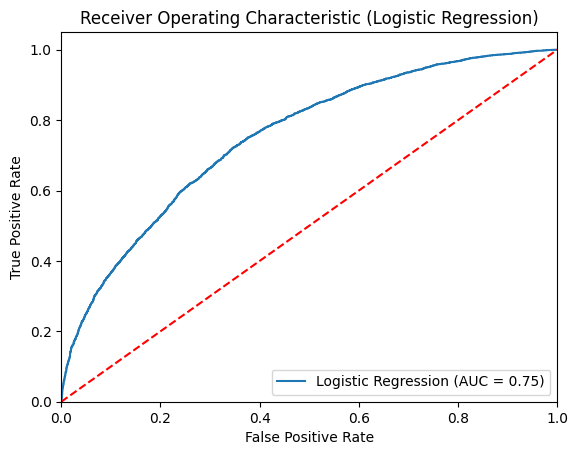

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (class 1)
y_prob_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC AUC
logistic_roc_auc = roc_auc_score(y_test, y_prob_logistic)
print('Logistic Regression ROC AUC:', logistic_roc_auc)

# Calculate ROC curve
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, y_prob_logistic)

# Plot ROC curve
plt.figure()
plt.plot(logistic_fpr, logistic_tpr, label='Logistic Regression (AUC = %0.2f)' % logistic_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Logistic Regression)')
plt.legend(loc="lower right")
plt.savefig('Logistic_Regression_ROC_Curve.png')
plt.show()


In [ ]:
logistic_model.coef_

array([[-0.59060978, -0.43268033,  0.27759545, -0.1119846 , -0.34636982,
         0.09282559,  0.42538013, -0.00758796,  0.07387539,  0.02863705,
         0.05726546, -0.03590328, -0.05205596, -0.0983518 ,  0.01910408,
        -0.00112658,  0.07571734,  0.04257697, -0.06967326,  0.02618354,
         0.04013789, -0.04013789,  0.06444247, -0.06444247,  0.00767727,
         0.0336707 ,  0.01213962, -0.06373696,  0.00857358,  0.06919123,
        -0.06919123, -0.03184249,  0.01782337,  0.00551235,  0.0111293 ,
        -0.00786737, -0.0940166 , -0.02268072,  0.10184241,  0.04473547,
         0.06409113,  0.06311452,  0.06735504]])

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(train_y, train_X)
logistic_model_2=logit_model.fit()
print(logistic_model_2.summary2())

Optimization terminated successfully.
         Current function value: 0.598046
         Iterations 5
                               Results: Logit
Model:                  Logit                Method:               MLE       
Dependent Variable:     Default              Pseudo R-squared:     0.137     
Date:                   2023-12-13 02:18     AIC:                  49702.5476
No. Observations:       41514                BIC:                  49909.7585
Df Model:               23                   Log-Likelihood:       -24827.   
Df Residuals:           41490                LL-Null:              -28775.   
Converged:              1.0000               LLR p-value:          0.0000    
No. Iterations:         5.0000               Scale:                1.0000    
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm

# Specify the significance level (alpha)
alpha_threshold = 0.01

# Fit the logistic regression model with the specified alpha
logit_model = sm.Logit(train_y, train_X)
logistic_model_2 = logit_model.fit(alpha=alpha_threshold)

# Display the summary
print(logistic_model_2.summary2())


/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: alpha. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 0.598046
         Iterations 5
                               Results: Logit
Model:                  Logit                Method:               MLE       
Dependent Variable:     Default              Pseudo R-squared:     0.137     
Date:                   2023-12-12 17:13     AIC:                  49702.5476
No. Observations:       41514                BIC:                  49909.7585
Df Model:               23                   Log-Likelihood:       -24827.   
Df Residuals:           41490                LL-Null:              -28775.   
Converged:              1.0000               LLR p-value:          0.0000    
No. Iterations:         5.0000               Scale:                1.0000    
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------

In [ ]:
# Set your custom p-value threshold
custom_alpha = 0.01

# Filter coefficients based on the threshold
non_significant_coefficients = logistic_model_2.pvalues[logistic_model_2.pvalues >= custom_alpha].index

# Display non-significant coefficients
print(non_significant_coefficients)


Index(['Education_Master's', 'Education_PhD', 'MaritalStatus_Single',
       'LoanPurpose_Home'],
      dtype='object')


# Optimized Logistic Model

Based on the logit regression summary p-values greater than 0.05 indicate non-significant effects on target variable. SkinThickness, Insulin, DiabetesPedigreeFunction & Age all had p-values that were greater than our threshold of 0.05 so we can allow to exclude these features from the model as the p-value shows there are not statistically significant effects on the outcome. We would rebuild our model with the remaining fatures which include: Pregnancies, Glucose, BloodPressure, & BMI.

In [ ]:
df.columns

Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education',
       'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents',
       'LoanPurpose', 'HasCoSigner', 'Default'],
      dtype='object')

In [ ]:
df_data_clean = df.drop(['Education_Master's', 'Education_PhD', 'MaritalStatus_Single',
       'LoanPurpose_Home'],axis=1)

KeyError: ignored

In [ ]:
X2 = diabetes_data_clean.drop('Outcome', axis = 1)
y2 = diabetes_data_clean['Outcome']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=1)

# Optimized2

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



X_with_const = sm.add_constant(X)
logit_model = sm.Logit(y, X_with_const).fit()
print(logit_model.summary())

p_value_threshold = 0.05

non_significant_features = [feature for feature in X.columns if logit_model.pvalues[feature] > p_value_threshold]

X_reduced = X.drop(non_significant_features, axis=1)

X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled_reduced = scaler.fit_transform(X_train_reduced)
X_test_scaled_reduced = scaler.transform(X_test_reduced)

logreg_reduced = LogisticRegression()
logreg_reduced.fit(X_train_scaled_reduced, y_train)
y_pred_reduced = logreg_reduced.predict(X_test_scaled_reduced)

accuracy = accuracy_score(y_test, y_pred_reduced)
precision = precision_score(y_test, y_pred_reduced)
recall = recall_score(y_test, y_pred_reduced)
f1 = f1_score(y_test, y_pred_reduced)
roc_auc = roc_auc_score(y_test, logreg_reduced.predict_proba(X_test_scaled_reduced)[:,1])

print("Model Performance with Reduced Features:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")




Optimization terminated successfully.
         Current function value: 0.590842
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                59306
Model:                          Logit   Df Residuals:                    59271
Method:                           MLE   Df Model:                           34
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.1476
Time:                        02:24:14   Log-Likelihood:                -35040.
converged:                       True   LL-Null:                       -41108.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.3431   8.51e+05   4.03e-07      1.00

# ANN

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_X)

train_X = scaler.transform(train_X)
valid_X = scaler.transform(valid_X)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [ ]:
MLPC_model = MLPClassifier(hidden_layer_sizes=20, activation='relu', solver='adam', random_state=1)

MLPC_model.fit(train_X, train_y)

y_pred_mlpc = MLPC_model.predict(valid_X)

print(confusion_matrix(valid_y,y_pred_mlpc))
print(classification_report(valid_y,y_pred_mlpc))

[[6361 2638]
 [2836 5957]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      8999
           1       0.69      0.68      0.69      8793

    accuracy                           0.69     17792
   macro avg       0.69      0.69      0.69     17792
weighted avg       0.69      0.69      0.69     17792



In [ ]:
print('ROC AUC: ', roc_auc_score(valid_y,y_pred_mlpc))

ROC AUC:  0.6921635163551727
